# Classification of ag plastics across California

Sentinel-2 classification of agricultural plastic use in California based on Harvard students' capstone project and Yuanyuan's internship project

Notebook authored by Annie Taylor, July 2024

Some key changes from previous analyses:
* Using validated training datasets (edited, added precise dates)
* Using different cloud-masking algorithm
* Using updated index equations
* Random stratified sample within polygons instead of sampling every point

### Set up ee api and packages

In [1]:
import ee
import geemap
import pandas as pd
import numpy as np
import matplotlib as mpl
import matplotlib.pyplot as plt
from matplotlib.lines import Line2D
import matplotlib.dates as mdates
from IPython.display import display, HTML
from datetime import datetime, timedelta
from sklearn.metrics import confusion_matrix
from sklearn.metrics import ConfusionMatrixDisplay
import geopandas as gpd
import altair as alt
import rasterio #used for pt sampling in section 8
from rasterio.plot import show
import seaborn as sns
import os
from rasterio.mask import mask # for area calc, can probably delete
import rioxarray
import xarray


In [2]:
# ee.Authenticate()
# ee.Initialize(project='ee-tnc-annietaylor')
cloud_project = 'ee-tnc-annietaylor'
try:
    ee.Initialize(project=cloud_project)
except:
    ee.Authenticate()
    ee.Initialize(project=cloud_project)


Successfully saved authorization token.


### Old training dataset import/stats

In [ ]:
# Training data - import from repo 
# Import the csvs with lat/longs as dfs (could all be one csv/df, keeping separate for testing)
# train_path = "N:/OCEANS_Program/Plastics/Agricultural_Plastics/Validated Training Data/" # can use this when connected to VPN 
train_path = 'data/Validated_Training_Data/'
santamaria = pd.read_csv(train_path + 'SantaMaria_val_o.csv')
mendocino = pd.read_csv(train_path + 'MendocinoCounty_val_o.csv')
# watsonville = pd.read_csv(train_path + 'Watsonville_val.csv')
watsonville = pd.read_csv(train_path + 'Watsonville_val_BM.csv')
# replace 'black mulch' with 'blackmulch' to avoid issues with space in label
watsonville['Type'] = watsonville['Type'].replace('black mulch', 'blackmulch')
oxnard_original = pd.read_csv(train_path + 'YYT_RElabeled_points_date_fixed.csv')
# Drop the 'TARGET_FID' column from the 'oxnard' DataFrame - shouldn't need this anymore
# oxnard_original = oxnard_original.drop('TARGET_FID', axis=1)
oxnard_add = pd.read_csv(train_path + 'Oxnard_additional_val.csv')
oxnard = pd.concat([oxnard_original, oxnard_add], axis=0, ignore_index=True)
# importing new other trees dataset
othertrees = pd.read_csv(train_path + 'Brandee_Other_Trees_2025.csv')

# Print out unique 'Type' values for each df to check for typos
print('Checking for typos in the Type column:')
# all_dfs = [santamaria, mendocino, watsonville, oxnard]
all_dfs = [santamaria, watsonville, oxnard, othertrees]
for df in all_dfs:
    print(df['Location'].iloc[0])
    print('\tunique types', df['Type'].unique())
    print('\tnumber of rows:', df.shape[0])

all_data = pd.concat(all_dfs, axis=0, ignore_index=True)
print('Total number of training points:', all_data.shape[0])
print('\tunique types', all_data['Type'].unique())
print('Number of rows in each class of Type:')
print(all_data['Type'].value_counts())
# print('unique dates:', all_data['Date'].unique())

# removing unused dates from the training data to get metadata/stats

all_data_test = all_data
# remove dates before 2018-05-09
all_data_test['Date'] = pd.to_datetime(all_data_test['Date']).dt.strftime('%Y-%m-%d')
all_data_test = all_data_test[all_data_test['Date'] > '2018-05-09']
all_data_test = all_data_test[all_data_test['Type'] != 'greenhouse']
print('unique dates:', all_data_test['Date'].unique())
print('Total number of training points:', all_data_test.shape[0])
print('\tunique types', all_data_test['Type'].unique())
print('Number of rows in each class of Type:')
print(all_data_test['Type'].value_counts())
print(all_data_test['Location'].value_counts())
# display('Watsonville dates: ', all_data_test[all_data_test['Location'] == 'Watsonville']['Date'].unique())
# display('Oxnard dates: ', all_data_test[all_data_test['Location'] == 'Oxnard']['Date'].unique())
# display('Santa Maria dates: ', all_data_test[all_data_test['Location'] == 'Santa Maria']['Date'].unique())

# # print a chart showing the number of points per date, stratified by Location
# # Group the data by 'Date' and 'Location' and count the number of points
# grouped_data = all_data_test.groupby(['Date', 'Location']).size().reset_index(name='Count')
# pivot_data = grouped_data.pivot(index='Date', columns='Location', values='Count').fillna(0)
# pivot_data.plot(kind='bar', stacked=True, figsize=(15, 7))
# plt.title('Number of Points per Date Stratified by Location')
# plt.xlabel('Date')
# plt.ylabel('Number of Points')
# plt.xticks(rotation=45, ha='right')
# plt.legend(title='Location')
# plt.tight_layout()
# plt.show()


Checking for typos in the Type column:
Santa Maria
	unique types ['hoop' 'mulch' 'other']
	number of rows: 1748
Watsonville
	unique types ['mulch' 'hoop' 'other' 'blackmulch' 'greenhouse']
	number of rows: 2346
Oxnard
	unique types ['hoop' 'mulch' 'blackmulch' 'other']
	number of rows: 1533
CA
	unique types ['other']
	number of rows: 165
Total number of training points: 5792
	unique types ['hoop' 'mulch' 'other' 'blackmulch' 'greenhouse']
Number of rows in each class of Type:
Type
other         2682
mulch         1527
hoop          1407
blackmulch     149
greenhouse      27
Name: count, dtype: int64
unique dates: ['2022-08-26' '2023-05-05' '2022-03-10' '2021-02-06' '2020-09-26'
 '2021-09-27' '2022-09-11' '2023-04-12' '2019-11-17' '2023-07-09'
 '2023-11-09' '2019-10-14' '2023-05-06' '2022-10-01' '2022-11-01'
 '2018-11-19' '2019-04-01' '2019-05-17' '2022-09-21' '2022-06-13'
 '2021-07-13' '2023-10-17' '2020-02-15' '2023-05-11' '2019-08-19'
 '2023-05-07' '2023-08-01' '2021-02-28' '2023-05-

### Import new field/date split and spatially not-autocorrelated training/validation dataset

In [43]:
# load data
training = pd.read_csv('data/AllTraining_080425prj_SJfiltered.csv')
# combine all black mulch types into one
training['Type'] = training['Type'].replace('black mulch', 'blackmulch')
# set date column to EE format
training['Date'] = pd.to_datetime(training['Date']).dt.strftime('%Y-%m-%d')

# Stats, optional:
print('Total number of training points:', training.shape[0])
# print('\tunique types', training['Type'].unique())
# print('Number of rows in each class of Type:\n', training['Type'].value_counts())
# print('Unique dates:', training['Date'].unique())
# print('Number of rows in each location:\n', training['Location'].value_counts())
# convert date to datetime format for consistency
# training['Date'] = pd.to_datetime(training['Date']).dt.strftime('%Y-%m-%d')



Total number of training points: 4122


### Load EE data

In [44]:
# California boundary
ca = ee.FeatureCollection("TIGER/2018/States").filter(ee.Filter.equals('NAME', 'California'))
# Agricultural areas from CA DWR's crop maps, 2019 to 2022 inclusive (10m raster)
# crops = ee.Image('projects/ee-annalisertaylor/assets/TNC/agplastics/dwr_allyears')
# Agricultural areas from CA DWR's crop maps, 2019 to 2023 inclusive (10m raster)
crops = ee.Image('projects/ee-tnc-annietaylor/assets/agplastics/dwr_allyears_23')

# County boundaries for spatial filtering 
county_bnd = ee.FeatureCollection("TIGER/2016/Counties").filterBounds(ca)
# make features of the counties you want for filtering/analysis
ventura = county_bnd.filter(ee.Filter.eq('NAME', 'Ventura'))
mendo = county_bnd.filter(ee.Filter.eq('NAME', 'Mendocino'))
cruz = county_bnd.filter(ee.Filter.eq('NAME', 'Santa Cruz'))
santabarbara = county_bnd.filter(ee.Filter.eq('NAME', 'Santa Barbara'))
kern = county_bnd.filter(ee.Filter.eq('NAME', 'Kern'))
humboldt = county_bnd.filter(ee.Filter.eq('NAME', 'Humboldt'))
sanbenito = county_bnd.filter(ee.Filter.eq('NAME', 'San Benito'))
# to read all the county options
# county_df = geemap.ee_to_df(county_bnd)
# pd.set_option('display.max_rows', 75)
# county_df['NAME']

# Encode labels - ee classifier requires numeric class labels
class_mapping = {'hoop': 0, 'mulch': 1, 'other': 2, 'blackmulch': 3}
# only watsonville has greenhouse points right now, santa maria has a separate (unimported) dataset
# but there are no greenhouse points in the cleaned up training dataset

## 1. Process Sentinel-2 Imagery

### Cloud filter the image collection

In [17]:
startDate = ee.Date.fromYMD(2010, 1, 1) # setting these to be inclusive for now, can change
endDate = ee.Date.fromYMD(2025, 10, 1)

s2 = ee.ImageCollection('COPERNICUS/S2_SR_HARMONIZED') \
    .filter(ee.Filter.date(startDate, endDate)) \
    .filter(ee.Filter.bounds(ca)) \
    .filter(ee.Filter.lt('CLOUDY_PIXEL_PERCENTAGE', 92))
    # .filter(ee.Filter.lt('CLOUDY_PIXEL_OVER_LAND_PERCENTAGE', 92)) #trying another property for clouds covering land
    # this causes an error bc it was added as a property more recently    

#### Cloud filtering with the s2_cloudless collection

In [18]:
# cloud mask using the cloudless image collection, pulling from EE documentation example
s2cloud = ee.ImageCollection('COPERNICUS/S2_CLOUD_PROBABILITY')
s2cloud = s2cloud.filterBounds(ca)
MAX_CLOUD_PROBABILITY = 15

def maskClouds(img):
    clouds = ee.Image(img.get('cloud_mask')).select('probability')
    isNotCloud = clouds.lt(MAX_CLOUD_PROBABILITY)
    return img.updateMask(isNotCloud)

# Masks for the 10m bands can include bad data at scene edge; apply masks from the 20m and 60m bands too
def maskEdges(s2_img):
    return s2_img.updateMask(s2_img.select('B8A').mask().updateMask(s2_img.select('B9').mask()))

# So I can investigate how this is performing above plastic cover
def addCloudless(img):
    cloud_prob = ee.Image(img.get('cloud_mask')).select('probability')
    return img.addBands(cloud_prob.rename('cloud_probability'))

# Filter s2cloud to same region, fix 10m pixels at edges
s2_mask = s2.map(maskEdges)

# Join S2 with cloud probability dataset to add cloud mask
# cloudless image is saved as a property called 'cloud_mask' in the original image
s2sr_cloudmask = ee.Join.saveFirst('cloud_mask').apply(primary=s2_mask, secondary=s2cloud, \
                            condition=ee.Filter.equals(leftField='system:index', rightField='system:index'))

# create the cloud masked image collection
s2_cldmsk = ee.ImageCollection(s2sr_cloudmask).map(maskClouds)

# create an image collection with the cloud probability band, not yet masked
# this is for testing to see what values certain pixels have
s2_cld_test = ee.ImageCollection(s2sr_cloudmask).map(addCloudless)

#### Cloud filtering with the QA band 
Checked this out after seeing problems with the s2_cloudless filter, but apparently this band doesn't contain any info from feb 2022 to feb 2024 so it's not usable

In [19]:
def mask_s2_clouds(image):
   qa = image.select('QA60')
   # Bits 10 and 11 are clouds and cirrus, respectively.
   cloud_bit_mask = 1 << 10
   cirrus_bit_mask = 1 << 11
   # Both flags should be set to zero, indicating clear conditions.
   mask = (qa.bitwiseAnd(cloud_bit_mask).eq(0).And(qa.bitwiseAnd(cirrus_bit_mask).eq(0)))
   return image.updateMask(mask)

s2_qa_cldmsk = s2.map(mask_s2_clouds)

#### Cloud filtering with MSK_CLDPRB band

In [20]:
cloud_threshold = 10

def mask_s2_clouds_cm(image):
   cm = image.select('MSK_CLDPRB')
   isNotCloud = cm.lt(MAX_CLOUD_PROBABILITY)
   return image.updateMask(isNotCloud)

s2_cm_cldmsk = s2.map(mask_s2_clouds_cm)

#### Cloud filtering with the SCL band -- this is what we're using

In [21]:
# 8 = Clouds Medium Probability
# 9 = Clouds High Probability
# 10 = Cirrus

def mask_s2_clouds_scl(image):
    scl = image.select('SCL')
    isNotCloud = scl.neq(8).And(scl.neq(9).And(scl.neq(10)))
    return image.updateMask(isNotCloud)

s2_scl_cldmsk = s2.map(mask_s2_clouds_scl)

### Vis params

In [22]:
rgbVis = {'min': 400, 'max': 1500, 'bands': ['B4', 'B3', 'B2']}
RPGI_viz = {'min': -0.9, 'max': -0.4, 'palette': ['#4d004b', '#f7fcfd']}
NDTI_viz = {'min': 0.0, 'max': 0.2, 'palette': ['white', 'yellow', 'orange']}
# visualize the classified plastic
plastic_viz = {'palette': ['FF5733', 'F4F31D', '2596be', '#333333'], 'min': 0, 'max': 3}
et_viz = {
  'min': 0,
  'max': 100,
  'palette': [
    '9e6212', 'ac7d1d', 'ba9829', 'c8b434', 'd6cf40', 'bed44b', '9fcb51',
    '80c256', '61b95c', '42b062', '45b677', '49bc8d', '4dc2a2', '51c8b8',
    '55cece', '4db4ba', '459aa7', '3d8094', '356681', '2d4c6e',
  ]
}
band_viz = {'min':603, 'max': 2725}

### Add VIs

In [23]:
def addVIs(image):
    image = image.addBands(image.normalizedDifference(['B8', 'B4']).rename('NDVI'))
    # image = image.addBands(image.normalizedDifference(['B8', 'B12']).rename('NBR')) # one band at 20m
    image = image.addBands(image.normalizedDifference(['B8', 'B11']).rename('NDMI')) # one band at 20m
    image = image.addBands(image.normalizedDifference(['B3', 'B8']).rename('NDWI'))
    # image = image.addBands(image.expression("2.5 * ((b('B8') - b('B4')) / (b('B8') + 6 * b('B4') - 7.5 * b('B2') + 1))").rename('EVI'))
    image = image.addBands(image.normalizedDifference(['B11', 'B12']).rename('NDTI')) # swir1 and swir2, both 20m, tillage index
    image = image.addBands(image.expression("100 * (b('B2') * (b('B8') - b('B4')))/(1 - ((b('B2') + b('B3') + b('B8')) / 3))").rename('PGI')) # all 10m
    image = image.addBands(image.expression("b('B2')/(1 - ((b('B2') + b('B3') + b('B8')) / 3))").rename('RPGI'))
    image = image.addBands(image.normalizedDifference(['B11', 'B4']).rename('PMLI')) # one band at 20m
    image = image.addBands(image.normalizedDifference(['B11', 'B8']).rename('NDBI')) # one band at 20m   
    return image

def adjPGI(image):
    # TODO check if this threshold for NDBI is too high
    # set all bands in the image to 0 where NDVI is higher than 0.73 OR when NDBI is higher than 0.005
    PGI_adj = image.where(image.select('NDVI').gt(0.73), 0)
    PGI_adj = PGI_adj.where(PGI_adj.select('NDBI').gte(0.005), 0)
    # extract the 'PGI' band from that modified image, and add it to the original image with a new name
    image = image.addBands(PGI_adj.select('PGI').rename('PGI_adj'))   
    return image

# not using this right now, keeping it as a useful example for downsampling the NIR band
# will be more precise if we decide to publish any of these data
def addNBR_RS(image):
    # reduces the resolution of the NIR band (10m) to match the SWIR band (20m)
    #   using the mean of all pixels within the larger pixel
    swir = image.select('B12')
    swir_projection = swir.projection()
    nir = image.select('B8').reduceResolution(reducer=ee.Reducer.mean(), maxPixels=16).reproject(crs=swir_projection)
    js_math_exp = 'c = (a-b) / (a+b)'
    js_math_img = ee.Image().expression(
        expression=js_math_exp, opt_map={'a': nir, 'b': swir}
    ).rename('NBR_RS')
    image = image.addBands(js_math_img)
    return image


### Build the collection

In [24]:
# one for each method of cloud filtering, for comparison
# s2_cloudless
processedCollection = s2_cldmsk.map(addVIs)
processedCollection = processedCollection.map(adjPGI)
# scl map
processedCollection_scl = s2_scl_cldmsk.map(addVIs)
processedCollection_scl = processedCollection_scl.map(adjPGI)
# other cloud masks for testing
processedCollection_qa = s2_qa_cldmsk.map(addVIs)
processedCollection_cm = s2_cm_cldmsk.map(addVIs)

# Change the working image collection to the SCL cloud filtered one
processedCollection = processedCollection_scl

# display(processedCollection)
# print(processedCollection.size().getInfo())
# print(processedCollection.first().bandNames().getInfo())

In [25]:
# Select bands to sample from the sentinel-2 images
bands = [
    'B4', 'B3', 'B2', 'B6', 'B8', 'B11', 'B12',
    'NDVI', 'NDTI', 'PGI', 'RPGI', 'PMLI', 'NDBI', 'PGI_adj', 'NDWI', 'NDMI'
]

#### Match training data dates to clear sentinel-2 images

In [ ]:
# matching training data to sentinel images, first clear image on or after the point date
date_matching_wats = {
    'points_date': ['2020-09-26', '2021-09-27', '2022-09-11', '2023-04-12', '2019-11-17', '2023-07-09'],
    'image_date': ['2020-09-26', '2021-10-01', '2022-09-16', '2023-04-14', '2019-12-16', '2023-07-28'],
    'location': ['Watsonville']*6
}
date_matching_mendo = {
    'points_date': ['2021-06-02'],
    'image_date': ['2021-06-06'],
    'location': ['Mendocino']*1
}
date_matching_maria = {
    'points_date': ['2022-08-26', '2023-05-05', '2022-03-10', '2021-02-06'],
    'image_date': ['2022-08-29', '2023-05-11', '2022-03-12', '2021-02-10'],
    'location': ['Santa Maria']*4
}
date_matching_oxnard = {
    # as of 11.13.24, all oxnard dates are added
    # For 5-6-23, can use 5/11 (has clouds but not on those points specifically) or 4/21,
    # cloud free but 15 days prior
    # for 8-1-2023, clouds far from those specific points, take care if adding more points
    'points_date': ['2023-10-17', '2023-05-06', '2023-11-09', '2019-05-17', '2022-06-13',
                    '2021-07-13', '2022-10-01', '2022-11-01', '2019-10-14', '2020-02-15',
                    '2023-08-01', '2021-02-28', '2023-05-07', '2019-08-19', '2023-05-11',
                    '2019-04-01', '2022-09-21', '2018-11-19'],
    'image_date': ['2023-10-28', '2023-05-11', '2023-11-09', '2019-05-17', '2022-06-15',
                   '2021-07-15', '2022-10-03', '2022-11-02', '2019-10-24', '2020-02-16',
                   '2023-08-01', '2021-03-02', '2023-05-06', '2019-08-20', '2023-05-11',
                   '2019-04-02', '2022-09-23', '2018-12-15'],
    'location': ['Oxnard']*18
}

date_matching_other = {
    'points_date': ['2023-05-26', '2023-06-29', #morgan hill
                    '2023-04-27', '2022-03-10', #santa maria
                    '2023-11-09', #oxnard
                    '2023-07-13', '2023-07-08', #santa barbara
                    '2023-08-01', '2022-10-08', '2022-12-23'#maricopa
                    ],
    'image_date': ['2023-06-03', '2023-07-03',
                   '2023-05-11', '2022-03-12',
                   '2023-11-09',
                   '2023-07-15', '2023-07-10',
                   '2023-08-01', '2022-10-08', '2023-01-06'
                   ],

    'location': ['CA']*10
}

# Convert combined dictionary to dataframe
dates_wats = pd.DataFrame.from_dict(date_matching_wats)
dates_mendo = pd.DataFrame.from_dict(date_matching_mendo)
dates_maria = pd.DataFrame.from_dict(date_matching_maria)
dates_oxnard = pd.DataFrame.from_dict(date_matching_oxnard)
dates_other = pd.DataFrame.from_dict(date_matching_other)
# print(dates_wats, '\n', dates_mendo, '\n', dates_maria, '\n', dates_oxnard)

# combine dfs vertically
date_matching = pd.concat([dates_wats, dates_mendo, dates_maria, dates_oxnard, dates_other], axis=0, ignore_index=True)
# print(date_matching.sort_values(by='points_date'))

# # This is to check points on the map to get good image matching
# co = santabarbara # ventura, mendo, cruz, santabarbara

# # option to import points from csv to show them on the map
# watsonville_points = "N:/OCEANS_Program/Plastics/Agricultural_Plastics/Validated Training Data/Watsonville_val_BM.csv"
# oxnard_points = "N:/OCEANS_Program/Plastics/Agricultural_Plastics/Validated Training Data/YYT_RElabeled_points_date_fixed.csv"
# oxnard_points = "N:/OCEANS_Program/Plastics/Agricultural_Plastics/Validated Training Data/oxnard_onedate.csv"

# date = '2022-03-12'
# nextday = ee.Date(date).advance(1, 'day').format('YYYY-MM-dd')
# oneday = processedCollection.filterDate(date, nextday).median()
# oneday_original = s2.filterDate(date, nextday).median()

# m = geemap.Map()
# m.add_basemap('HYBRID')
# m.addLayer(oneday_original, rgbVis, 'original image')
# m.addLayer(oneday, rgbVis, 'cloud filtered')
# m.add_points_from_xy(oxnard_points, x="Longitude", y="Latitude")
# m.centerObject(co, 10)
# m

   points_date  image_date     location
28  2018-11-19  2018-12-15       Oxnard
26  2019-04-01  2019-04-02       Oxnard
14  2019-05-17  2019-05-17       Oxnard
24  2019-08-19  2019-08-20       Oxnard
19  2019-10-14  2019-10-24       Oxnard
4   2019-11-17  2019-12-16  Watsonville
20  2020-02-15  2020-02-16       Oxnard
0   2020-09-26  2020-09-26  Watsonville
10  2021-02-06  2021-02-10  Santa Maria
22  2021-02-28  2021-03-02       Oxnard
6   2021-06-02  2021-06-06    Mendocino
16  2021-07-13  2021-07-15       Oxnard
1   2021-09-27  2021-10-01  Watsonville
9   2022-03-10  2022-03-12  Santa Maria
32  2022-03-10  2022-03-12           CA
15  2022-06-13  2022-06-15       Oxnard
7   2022-08-26  2022-08-29  Santa Maria
2   2022-09-11  2022-09-16  Watsonville
27  2022-09-21  2022-09-23       Oxnard
17  2022-10-01  2022-10-03       Oxnard
37  2022-10-08  2022-10-08           CA
18  2022-11-01  2022-11-02       Oxnard
38  2022-12-23  2023-01-06           CA
3   2023-04-12  2023-04-14  Watsonville


##### calculate date gaps for manuscript

In [28]:
# # Convert columns to datetime format
# date_matching['points_date'] = pd.to_datetime(date_matching['points_date'])
# date_matching['image_date'] = pd.to_datetime(date_matching['image_date'])

# # Calculate the difference in days
# date_matching['days_difference'] = (date_matching['image_date'] - date_matching['points_date']).dt.days

# print(date_matching)
# print(date_matching['days_difference'].describe())

#### Investigate cloud filtering issues

In [21]:
# processedCollection = final collection with VIs added
# processedCollection2 = final collection with VIs added, using QA60 band for cloud filtering
# s2_cldmsk = cloud filtered version
# s2_qa_cldmsk = cloud filtered version using QA60 band
# s2_cm_cldmsk = cloud filtered version using MSK_CLDPRB band
# s2_cld_test = s2 with s2_cloudless data joined, not yet filtered
# s2 = original collection, filtered by date/ca/image cloudiness lt 92

# co = santabarbara # ventura, mendo, cruz, santabarbara
# images_original = processedCollection.filterBounds(co)
# # test_s2 = s2.filterBounds(co)
# images_cloudless = s2_cld_test.filterBounds(co) # get the original image with s2_cloudless probability added
# images_cm = processedCollection_cm.filterBounds(co)
# images_scl = processedCollection_scl.filterBounds(co)

# start = '2020-09-26' # sf cloudy image = '2022-01-01' 
# end = '2022-03-30'

# original = images_original.filterDate(start, end).first()
# original_cloudless = images_cloudless.filterDate(start, end).first()
# cm = images_cm.filterDate(start, end).first()
# scl = images_scl.filterDate(start, end).first()

# m = geemap.Map()
# m.addLayer(original, rgbVis, 'cloud filtered')
# m.addLayer(cm, rgbVis, 'cloud filtered CLDPRB')
# m.addLayer(scl, rgbVis, 'cloud filtered SCL')
# m.addLayer(original_cloudless, rgbVis, 'original image')
# m.centerObject(co, 10)
# m

### Evapotranspiration data

In [29]:
et = ee.ImageCollection('OpenET/ENSEMBLE/CONUS/GRIDMET/MONTHLY/v2_0').filterBounds(ca).select('et_ensemble_mad')

# https://developers.google.com/earth-engine/datasets/catalog/OpenET_ENSEMBLE_CONUS_GRIDMET_MONTHLY_v2_0#bands
# Using the ensemble value of ET = 'et_ensemble_mad'

# The ET data only goes through the end of 2023, which is okay with our current training data
# the function will error if we try to sample in 2024 (probably an 'image has no bands' error)

date = ee.Date('2022-07-17')
date = ee.Date(date.format('yyyy-MM-01'))

data = et.filterDate(date, date.advance(1, 'month'))
# display(data)

m = geemap.Map()
m.setCenter(-119.17, 34.19, 6)
m.addLayer(data, et_viz, 'Ensemble ET')
# m

#### compare resolutions of the three bands

In [31]:
date = '2022-03-12'
nextday = ee.Date(date).advance(1, 'day').format('YYYY-MM-dd')
oneday = processedCollection.filterDate(date, nextday).median()
# oneday_original = s2.filterDate(date, nextday).median()

m = geemap.Map()
m.setCenter(-119.17, 34.19, 6)
m.addLayer(data, et_viz, 'Ensemble ET')
m.addLayer(oneday.select('B12'), band_viz, 'B12') # SWIR2, 20m
m.addLayer(oneday.select('B8'), band_viz, 'B8') # NIR, 10m
# m

# print(processedCollection_scl.first().select('B8').projection().getInfo())
# print(processedCollection_scl.first().select('B12').projection().nominalScale().getInfo())
# data.first().projection()



In [32]:
# convert the sentinel image to the same projection as the ET data
# get the projection of the ET data 

test = ee.Image(processedCollection_scl.first())

et_projection = et.first().projection()
s2_projection_10m = test.select('B8').projection() #this is the projection of the 10m band
s2_projection_20m = test.select('B12').projection() # this is the projection of the 20m band

# print('ET projection:', et_projection.getInfo())
print('S2 projection 10m:', s2_projection_10m.getInfo())  
print('S2 projection 20m:', s2_projection_20m.getInfo())  

s2_resampled_10m = (
    test.setDefaultProjection(s2_projection_10m)
    # Force the next reprojection to aggregate instead of resampling
    .reduceResolution(reducer=ee.Reducer.mean())
    # Request the data at the scale and projection of the ET image
    .reproject(crs=et_projection)
)

s2_resampled_20m = (
    test.setDefaultProjection(s2_projection_20m)
    # Force the next reprojection to aggregate instead of resampling
    .reduceResolution(reducer=ee.Reducer.mean())
    # Request the data at the scale and projection of the ET image
    .reproject(crs=et_projection)
)

m = geemap.Map()
m.setCenter(-119.17, 34.19, 6)
m.centerObject(test, 10)
m.addLayer(data, et_viz, 'Ensemble ET')
m.addLayer(oneday.select('B12'), band_viz, 'B12', False) # SWIR2, 20m
m.addLayer(oneday.select('B8'), band_viz, 'B8', False) # NIR, 10m
m.addLayer(test.select('B12'), band_viz, 'B12 original') # NIR, 10m
m.addLayer(s2_resampled_10m.select('B8'), band_viz, 'resampled _10m') #NIR, 30m
m.addLayer(s2_resampled_20m.select('B8'), band_viz, 'resampled 20m') #NIR, 30m
# m

S2 projection 10m: {'type': 'Projection', 'crs': 'EPSG:32610', 'transform': [10, 0, 699960, 0, -10, 4400040]}
S2 projection 20m: {'type': 'Projection', 'crs': 'EPSG:32610', 'transform': [20, 0, 699960, 0, -20, 4400040]}


## Sample to new training dataset

Add matching sentinel image date to training dataset points

In [62]:
# training is my df of points with lat/longs, type label, date of high res image, and location 
# date_matching_loc matches the training points by date and location to the sentinel images

# Ensure 'Date' in training is in YYYY-MM-DD format for matching
training['Date'] = pd.to_datetime(training['Date']).dt.strftime('%Y-%m-%d')

# Copy date_matching and convert 'points_date' to YMD format for matching
date_matching_loc = date_matching.copy()
date_matching_loc['points_date'] = date_matching_loc['points_date'].dt.strftime('%Y-%m-%d')

# Merge on both 'Date' (training) <-> 'points_date' and 'Location' <-> 'location'
training_merged = training.merge(
    date_matching_loc[['points_date', 'location', 'image_date']],
    left_on=['Date', 'Location'],
    right_on=['points_date', 'location'],
    how='left'
)

# format image_date to YYYY-MM-DD
training_merged['image_date'] = pd.to_datetime(training_merged['image_date']).dt.strftime('%Y-%m-%d')

# Now training['image_date'] contains the matched image date for each point
display(training_merged.head())

# print unique date_loc values
# print('Unique date/location pairs in training data:', training_merged['Date_Loc'].unique())

# cut out region column
training_merged = training_merged.drop(columns=['Region'])

# check if training_merged has any NaN values
# print('NaN values:', training_merged.isnull().sum())

# which date_loc pairs have nan values for image_date?
nan_image_dates = training_merged[training_merged['image_date'].isnull()][['Date', 'Location']]
# print('Date/Location pairs with no matching image date:')
# print(nan_image_dates)

# filter training_merged to only include rows with non-null image_date
# take this out if I end up adding an image match to the watsonville points 5/9/18
training_merged = training_merged[training_merged['image_date'].notnull()]
# print the number of rows in training_merged
print('Number of rows in training_merged after filtering:', training_merged.shape[0])

Location        Date   Type       Region   Latitude   Longitude  Split  \
0       CA  2023-05-26  other  Morgan Hill  37.188061 -121.725901      1   
1       CA  2023-05-26  other  Morgan Hill  37.189068 -121.724510      1   
2       CA  2023-05-26  other  Morgan Hill  37.190223 -121.722561      1   
3       CA  2023-05-26  other  Morgan Hill  37.187451 -121.719603      1   
4       CA  2023-05-26  other  Morgan Hill  37.189402 -121.726455      1   

        Date_Loc  Orig_FID points_date location  image_date  
0  2023-05-26 CA         1  2023-05-26       CA  2023-06-03  
1  2023-05-26 CA         2  2023-05-26       CA  2023-06-03  
2  2023-05-26 CA         3  2023-05-26       CA  2023-06-03  
3  2023-05-26 CA         4  2023-05-26       CA  2023-06-03  
4  2023-05-26 CA         5  2023-05-26       CA  2023-06-03

Number of rows in training_merged after filtering: 3739


In [63]:
def sample_dates(df):
    # add a 'class' column to the df by mapping the 'Type' column to numeric values
    df['class'] = df['Type'].map(class_mapping)

    date_locations = df['Date_Loc'].unique()

    all_area_data = []

    # Iterate through all of the dates in the df
    for dl in date_locations:
        # Get df rows for that date/location pair
        df_dateloc = df[df['Date_Loc'] == dl]
        fc_date = geemap.df_to_ee(df_dateloc, latitude='Latitude', longitude='Longitude')
        # Get properties for this date/location pair
        date = df_dateloc['Date'].iloc[0]
        image_date = df_dateloc['image_date'].iloc[0]
        location = df_dateloc['Location'].iloc[0]
        # Filter images to only that one corresponding sampling date
        image_nextdate = ee.Date(image_date).advance(1, 'day').format('YYYY-MM-dd')
        sample_image = processedCollection.filterDate(image_date, image_nextdate).median()
        # Sample that image to the fc, keeping ‘class’ property
        data = sample_image.select(bands).sampleRegions(
            collection=fc_date,
            properties=['class', 'Latitude', 'Longitude', 'Split'],
            scale=10, #Reduces points within 10m of each other, should not be any
            geometries=True
        )

        # Also sample the monthly ET (30m scale, from landsat and other weather data)
        et_date = ee.Date(ee.Date(image_date).format('yyyy-MM-01')) #convert to first of month for ET data
        et_img = et.filterDate(et_date, et_date.advance(1, 'month')).median().rename('ET')
        data = et_img.sampleRegions(
            collection=data,
            scale=30, #Reduces points within 30m of each other, should not be any
            geometries=True
            # keep all properties from sampling points
        )
        # Add point date, sampled image date, and location as a property to each feature in the feature collection
        data = data.map(lambda feature: feature.set({
            'date': date,
            'image_date': image_date,
            'location': location
            }))

        # Append to list of fcs for each date/location pair
        all_area_data.append(data)

    # Flatten into one fc for the dataset
    area_fc = ee.FeatureCollection(all_area_data).flatten()
    return area_fc

# # Filter to two unique Date_Loc pairs for testing
# two_pairs = training_merged['Date_Loc'].unique()[:2]
# training_merged_subset = training_merged[training_merged['Date_Loc'].isin(two_pairs)]

# training_merged_subset_sampled = sample_dates(training_merged_subset)
# training_merged_subset_sampled

# Sample the training data for all dates/locations
training_merged_sampled = sample_dates(training_merged)


## 2. Sample each feature collection to build training dataset
This method uses image matching to ensure there are no cloudy pixels in the training data

Skip to 2b for faster running code if you haven't made changes to imagery / sampling methods

In [25]:
def sample_dates(df):
    # add a 'class' column to the df by mapping the 'Type' column to numeric values
    df['class'] = df['Type'].map(class_mapping)
    # Format dates to YYYY-MM-DD
    df['Date'] = pd.to_datetime(df['Date']).dt.strftime('%Y-%m-%d')

    # print('pre-filter', df['Date'].unique())
    # print(df.shape[0])

    # Drop greenhouse, drop points from before 2018-05-09
    df = df[df["Type"]!="greenhouse"]
    df = df[df['Date'] > '2018-05-09']
    # print('post-filter', df['Date'].unique())
    # print(df.shape[0])
    
    # get the location of the df to be sampled
    location = df['Location'].iloc[0]
    # filter the date_matching df to this location
    date_matching_loc = date_matching[date_matching['location'] == location]
    # Filter for only dates that have a matched sampling image, should be all now
    df = df.loc[df['Date'].isin(date_matching_loc['points_date'])]

    dates = df['Date'].unique()
    # print('post-filter', dates)

    all_area_data = []

    # Iterate through all of the dates in the df
    for date in dates:
        # Get df rows for that date
        df_date = df[df["Date"]==date]
        fc_date = geemap.df_to_ee(df_date, latitude='Latitude', longitude='Longitude')
        # Get image date from the date_matching df
        image_date = date_matching_loc.loc[date_matching_loc['points_date'] == date, 'image_date'].iloc[0]
        # Filter images to only that one corresponding sampling date
        image_nextdate = ee.Date(image_date).advance(1, 'day').format('YYYY-MM-dd')
        sample_image = processedCollection.filterDate(image_date, image_nextdate).median()
        # Sample that image to the fc, keeping ‘class’ property
        data = sample_image.select(bands).sampleRegions(
            collection=fc_date,
            properties=['class', 'Latitude', 'Longitude'],
            scale=10, #Reduces points within 10m of each other
            geometries=True
        )

        # Also sample the monthly ET (30m scale, from landsat and other weather data)
        et_date = ee.Date(ee.Date(image_date).format('yyyy-MM-01')) #convert to first of month for ET data
        et_img = et.filterDate(et_date, et_date.advance(1, 'month')).median().rename('ET')
        data = et_img.sampleRegions(
            collection=data,
            scale=30, #I believe 30m scale reduces points within 30m of each other
            geometries=True
        )
        # Add point date, sampled image date, and location as a property to each feature in the feature collection
        data = data.map(lambda feature: feature.set({
            'date': date,
            'image_date': image_date,
            'location': location
            }))

        # Append to list of fcs for each date
        all_area_data.append(data)

    # Flatten into one fc for the dataset
    area_fc = ee.FeatureCollection(all_area_data).flatten()
    return area_fc

In [26]:
# test = sample_dates(othertrees)
# print(test.size().getInfo())
# test_df = geemap.ee_to_df(test)
# test_df
# filtered = date_matching[date_matching['location'] == 'Oxnard']
# print(filtered)
# display('after sampling', test_df['class'].value_counts())
# display('before sampling', oxnard['Type'].value_counts())
# print(class_mapping)

# make a df with manually entered points
# but you would also have to add to date_matching for any new image dates
# data_points = [
#     ['Oxnard', '8/1/2023', 'mulch', -119.257339, 34.260933]
# ]
# other_points = pd.DataFrame(data_points, columns=['Location', 'Date', 'Type', 'Longitude', 'Latitude'])
# test

# santamaria printout says 298, excel file is 768. total rows matches. my filtering function is 768.
# mendo is right (none)
# watsonville printout says 65, excel file is 464. total rows matches. my filtering function is 464 (accounting for greenhouse points)
# oxnard printout says 578, excel files (2) are 0. total rows 1474 + 59 = 1533 matches. my filtering function is 1533.
# so all of the filtering is working as I expect

In [27]:
# On 9.20.24, removed mendocino training data from the model 
# mendo_training = sample_dates(mendocino)
watsonville_training = sample_dates(watsonville)
santamaria_training = sample_dates(santamaria)
oxnard_training = sample_dates(oxnard)
# On 1.30.25 added other trees dataset
othertrees_training = sample_dates(othertrees)

# Combine all data - list of feature collections
all_data = []
# all_data.append(mendo_training)
all_data.append(watsonville_training)
all_data.append(santamaria_training)
all_data.append(oxnard_training)
all_data.append(othertrees_training)

# generate a random number column for training/validation split
data = ee.FeatureCollection(all_data).flatten().randomColumn(seed=0)

In [64]:
# save the fc as an asset to drastically speed up later anaylsis
# have to delete this asset first, can't overwrite it

data = training_merged_sampled

asset_id = 'projects/ee-tnc-annietaylor/assets/agplastics/training_v_1_2'
task = ee.batch.Export.table.toAsset(
    collection=data,
    description='Export training data to asset',
    assetId=asset_id
)
task.start()

## 2b Import training data as fc instead of building it

In [ ]:
# import the fc with training data prepped for each version of the model
# asset_id = 'projects/ee-tnc-annietaylor/assets/agplastics/labeled_point_data_matched_ET_BM_o_nm_ox_all' #v0.9
# asset_id = 'projects/ee-tnc-annietaylor/assets/agplastics/labeled_point_data_matched_ET_BM_o_nm_ox_all_trees' #v1.0
# asset_id = 'projects/ee-tnc-annietaylor/assets/agplastics/labeled_point_data_matched_ET_BM_o_nm_ox_all_trees_pgi' #v1.1
asset_id = 'projects/ee-tnc-annietaylor/assets/agplastics/training_v_1_2' #v1.2
data = ee.FeatureCollection(asset_id)

### 2c violin plots

In [30]:
data_df = geemap.ee_to_df(data)
class_mapping_reversed = {v: k for k, v in class_mapping.items()}
data_df['Type'] = data_df['class'].map(class_mapping_reversed)
# data_df.head()

In [31]:
# select the band of interest for plotting
boi = "NDTI"
# NDTI, ET, RPGI, B12, NDVI, NDMI, B11, PGI, B6, NDBI, B2, NDWI
# NDTI	7.942652
# B12	6.935348
# B11	6.820965
# RPGI	6.612448
# B2	6.566569
# NDMI	6.226701
# PGI	6.178141
# ET	

In [32]:
chart = alt.Chart(data_df).mark_boxplot().encode(
    alt.X("Type:N", sort=['other', 'hoop', 'mulch', 'blackmulch']),
    alt.Y(boi).scale(zero=False),
    alt.Color("Type:N"),
    alt.Tooltip("image_date:T")
).properties(width=300)

countlabel = alt.Chart(data_df).mark_text(align='center', dy=-130, fontWeight=100, fontSize=10).encode(
    x='Type:N',
    text='label:N'
).transform_joinaggregate(
    n_count = 'count(Type)',
    groupby=['Type']
).transform_calculate(
    label = "'n = ' + datum.n_count"
)

# chart + countlabel

In [33]:
chart2 = alt.Chart(data_df, width=100).transform_density(
    boi,
    as_=[boi, 'density'],
    groupby=['Type']
).mark_area(orient='horizontal').encode(
    alt.X('density:Q')
        .stack('center')
        .impute(None)
        .title(None)
        .axis(labels=False, values=[0], grid=False, ticks=True),
    alt.Y(boi),
    alt.Color('Type:N'),
    alt.Column('Type:N', sort=['other', 'hoop', 'mulch', 'blackmulch'])
        .spacing(0)
        .header(titleOrient='bottom', labelOrient='bottom', labelPadding=0)
).configure_view(
    stroke=None
)

# chart2
display(chart + countlabel, chart2)

alt.LayerChart(...)

alt.Chart(...)

## 3. Split training and validation data

#### merge blackmulch class into mulch class
Slightly higher overall accuracy and higher recall (aka fewer mulch points missed)

In [34]:
# combine black mulch and mulch classes as this slightly improved model performance
# data.first().get('class').getInfo()
data = data.map(lambda feature: feature.set('class', ee.Algorithms.If(ee.Number(feature.get('class')).eq(3), 1, feature.get('class'))))

In [35]:
# Process data (1): Train test split
# print(f"Total number of labeled data:", data.size().getInfo())
split = 0.7
training = data.filter(ee.Filter.lt('random', split))
validation = data.filter(ee.Filter.gte('random', split))
# print(f"Number of training points: {training.size().getInfo()}")
# print(f"Number of validation points: {validation.size().getInfo()}")

#### Training data stats

In [36]:
# convert to dfs for easier stats
# training_df = geemap.ee_to_df(training)
# validation_df = geemap.ee_to_df(validation)

# print(f"Number of training points: {training_df.shape[0]}")
# print(f"Number of validation points: {validation_df.shape[0]}")

# Check number of data in each county
# print("Number of training points:", training_df['county'].value_counts())
# print("Number of validation points:", validation_df['county'].value_counts())

#### Address spatial autocorrelation
- Remove points within 30 meters of each other between the training and validation datasets
- DOES NOT ADDRESS SPATIAL AUTOCORRELATION W/IN THESE DATASETS and also the fact that many of these points are from different dates :/ 

##### this is where kirk and I left off #2

In [37]:
# Process data (2): Address autocorrelation correction
# TODO how are we addressing spatial autocorrelation within each dataset?
# right now this is simply removing any training data points within 30m of a validation point
distFilter = ee.Filter.withinDistance(
    distance=30,
    leftField='.geo',
    rightField='.geo',
    maxError=10
)
join = ee.Join.inverted()
training = join.apply(training, validation, distFilter)
# print(f"Number of training points after removing autocorrelation: {training.size().getInfo()}")


# only need to worry about this within dates, within the same week for example
# if val point is too close to training point, we're not actually testing our model
# should we validate points from new fields -- this is kirk's preference
# use lat long and time to cluster points, break this into n groups
#  wihtin this time period, 
# geographic clusters per year and per region
# or i could set a max number of points per cluster

In [38]:
# convert to dfs for easier stats again
training_df = geemap.ee_to_df(training)
# Check number of training data in each region again
display("Number of training points:", training_df['location'].value_counts())
# training_df.head(5)
# training

'Number of training points:'

location
Watsonville    852
Oxnard         744
Santa Maria    634
CA             106
Name: count, dtype: int64

In [39]:
# print("Number of training points of each class:", training_df['class'].value_counts())
for class_name, class_id in class_mapping.items():
   filtered_df = training_df[training_df['class'] == class_id]
   print(f"Number of points labeled {class_name}: {filtered_df.shape[0]}")

Number of points labeled hoop: 527
Number of points labeled mulch: 604
Number of points labeled other: 1205
Number of points labeled blackmulch: 0
Number of points labeled greenhouse: 0


## 4. Train and Evaluate Models

### Random Forest

In [40]:
# bands to train the model on
bands_tr = [
    'B4', 'B3', 'B2', 'B6', 'B8', 'B11', 'B12',
    'NDVI', 'NDTI', 'PGI', 'RPGI', 'PMLI', 'NDBI', 'PGI_adj', 'NDWI', 'NDMI',
    'ET'
]

In [41]:
# Train and test the RF model
# trying it with probability output
trained_RF = ee.Classifier.smileRandomForest(50).train(training, 'class', bands_tr)
trainAccuracy_RF = trained_RF.confusionMatrix()

classifications_RF = validation.classify(trained_RF)
validationAccuracy_RF = classifications_RF.errorMatrix('class', 'classification')

# print out accuracy information
print(f"\tTraining accuracy:{trainAccuracy_RF.accuracy().getInfo()}")
print(f"\tValidation accuracy:{validationAccuracy_RF.accuracy().getInfo()}")
# trained_RF.explain()
# takes about 2 min to run if you have recreated instead of importing the training data, otherwise super fast
# classifications_RF

	Training accuracy:0.9961472602739726
	Validation accuracy:0.9278033794162827


In [42]:
# this gives f score for each class (hoop, mulch, other) (blackmulch combined now)
validationAccuracy_RF.fscore().getInfo()

[0.9305019305019305, 0.8963503649635035, 0.9421841541755889]

#### Confusion matrices

Text(0.5, 1.0, 'RF Confusion Matrix (92.78% Accuracy)')

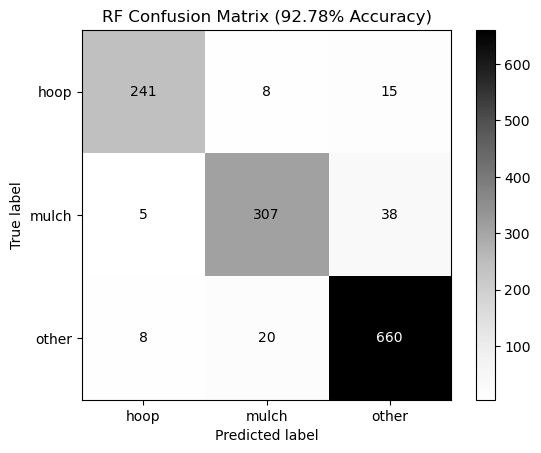

In [43]:
# Plot confusion matrix
# display_labels = ['hoop', 'mulch', 'other', 'blackmulch']
display_labels = ['hoop', 'mulch', 'other']

cm_RF = np.array(validationAccuracy_RF.getInfo())
disp = ConfusionMatrixDisplay(confusion_matrix=cm_RF, display_labels=display_labels)
disp.plot(cmap=plt.cm.Greys)
disp.ax_.set_title(f"RF Confusion Matrix ({validationAccuracy_RF.accuracy().getInfo():.2%} Accuracy)")

#### Variable Importances

In [44]:
importance = ee.Dictionary(trained_RF.explain().get('importance'))

totalImportance = importance.values().reduce(ee.Reducer.sum())

# helper fn to map over importance values
def percentConvert(key, val):
    return ee.Number(val).divide(totalImportance).multiply(100)
relImportance = importance.map(percentConvert)

importanceFC = ee.FeatureCollection([ee.Feature(None, relImportance)])
# convert to pandas df
varImportance = geemap.ee_to_df(importanceFC)

varImportance = varImportance.transpose().rename(columns={0: 'Importance'})
varImportance = varImportance.sort_values(by='Importance', ascending=False)
varImportance

# varImportance.plot(kind='bar')
# plt.show()

Importance
NDTI       7.197764
B6         7.144888
RPGI       7.127109
ET         6.818540
B11        6.759843
B12        6.540195
PGI        6.289633
B2         6.029740
B8         5.879102
B3         5.697986
NDWI       5.622855
PMLI       5.610360
NDMI       5.475129
NDBI       5.434042
NDVI       5.018401
B4         4.866202
PGI_adj    2.488213

#### Reproducible/condensed version
Useful for debugging

In [45]:
# # Reproducible version to test errors
# # import the training data - points labeled with class (0, 1, 2) and containing sampled band info
# asset_id = 'projects/ee-annalisertaylor/assets/TNC/agplastics/labeled_point_data' # needs to be read-only/public
# data = ee.FeatureCollection(asset_id)
# # subset the training data by approx 70% for training (and 30% for validation)
# training = data.filter(ee.Filter.lt('random', 0.7))
# bands = ['B4', 'B3', 'B2', 'B6', 'B8', 'B11', 'B12', 'NDVI', 'NDTI', 'PGI', 'RPGI', 'PMLI']

# trained_RF = ee.Classifier.smileRandomForest(50).train(training, 'class', bands)

# importance = ee.Dictionary(trained_RF.explain().get('importance'))

# totalImportance = importance.values().reduce(ee.Reducer.sum())

# # helper fn to map over importance values
# def percentConvert(key, val):
#     return ee.Number(val).divide(totalImportance).multiply(100)
# relImportance = importance.map(percentConvert)

# importanceFC = ee.FeatureCollection([ee.Feature(None, relImportance)])
# # convert to pandas df
# varImportance = geemap.ee_to_df(importanceFC)
# varImportance

## 5. Export the model

per [ee docs](https://developers.google.com/earth-engine/apidocs/export-classifier-toasset#colab-python), allows you to build larger models (i.e. more trees, more training samples)

In [46]:
# rf_asset_id = 'projects/ee-tnc-annietaylor/assets/agplastics/RF_classifier_matched_ET_BM_o_nm_ox_all_trees_pgi'
# task = ee.batch.Export.classifier.toAsset(
#     classifier=trained_RF,
#     description='classifier_export',
#     assetId=rf_asset_id
# )
# task.start()

## 6. Apply standard classification model to imagery

In [47]:
# bring in the saved classifier
rf_asset_id = 'projects/ee-tnc-annietaylor/assets/agplastics/RF_classifier_matched_ET_BM_o_nm_ox_all_trees_pgi'
savedClassifier = ee.Classifier.load(rf_asset_id)

#### Get all images from one date, stitch them together, and center the map on that

In [48]:
# for a given date, get images from that date, stitch them together, and center the map on that
# for watsonville ground-truthing, use date = '2021-10-01' and Earth image date 9/30/2021
# https://earth.google.com/web/@36.90600071,-121.7366486,5.73571404a,18340.9275927d,35y,0h,0t,0r/data=ChIqEAgBEgoyMDIxLTA5LTMwGAE6AwoBMA
# for oxnard ground-truthing, use date = '2022-07-05' and Earth image date 6-30-2022
# https://earth.google.com/web/@34.18104511,-119.12299165,16.77976172a,20704.65705214d,35y,0h,0t,0r/data=ChIqEAgBEgoyMDIyLTA2LTMwGAE6AwoBMA
# for santa maria, use date = '2021-03-02' and Earth image date 2-28-2021
# https://earth.google.com/web/@34.92298797,-120.36568793,104.77571464a,20361.02485151d,35y,0h,0t,0r/data=ChIqEAgBEgoyMDIxLTAyLTI4GAE6AwoBMA
# for mendocino, use date = '2021-07-01' and Earth image date 6-30-2021 (have to also take off crop mask)
# https://earth.google.com/web/@39.49685652,-123.43778648,742.16477863a,4440.61517426d,35y,0h,0t,0r/data=ChIqEAgBEgoyMDIxLTA2LTMwGAE6AwoBMA

date = '2023-10-03'
nextday = ee.Date(date).advance(1, 'day').format('YYYY-MM-dd')
oneday = processedCollection.filterDate(date, nextday).median()
oneday_original = s2.filterDate(date, nextday).median()

# get ET data for the month of that date
et_date = ee.Date(ee.Date(date).format('yyyy-MM-01')) #convert to first of month for ET data
et_img = et.filterDate(et_date, et_date.advance(1, 'month')).median().rename('ET')

# add ET band to sentinel-2 image
oneday = oneday.addBands(et_img)

### Classify the image and add to map

In [49]:
# make the crop mask
crops = crops.where(crops, 1)

# classify the image
classified = oneday.classify(savedClassifier).updateMask(crops)

# add the classified plastic and composite image to map
m = geemap.Map()
# m.add_basemap('HYBRID')
m.addLayer(oneday_original, rgbVis, 'Full Sentinel: ' + date)
m.addLayer(oneday.select('RPGI'), RPGI_viz, 'RPGI', False)
m.addLayer(oneday.select('NDTI'), NDTI_viz, 'NDTI', False)
m.addLayer(oneday, rgbVis, 'Cloudless Sentinel: ' + date)
m.addLayer(classified, plastic_viz, 'Classified Plastic')
m.centerObject(ca, 6)
m

Map(center=[37.152434104671315, -119.52655155150876], controls=(WidgetControl(options=['position', 'transparen…

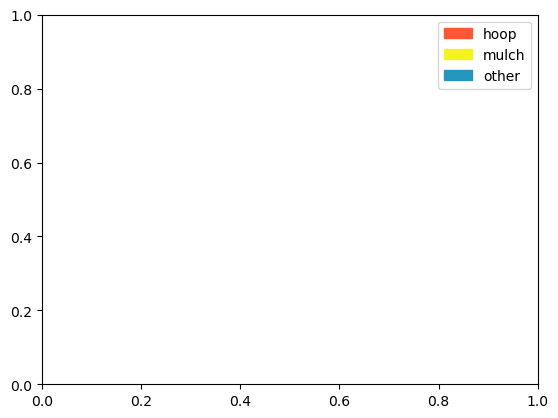

In [50]:
# print out the map legend
# colors = ['#FF5733', '#F4F31D', '#2596be', '#333333']
# labels = ['hoop', 'mulch', 'other', 'blackmulch']
colors = ['#FF5733', '#F4F31D', '#2596be']
labels = ['hoop', 'mulch', 'other']

# Create a legend with the colors and labels
patches = [plt.Rectangle((0, 0), 1, 1, color=color) for color in colors]
plt.legend(patches, labels)

plt.show()

### Multi-probability classifier

In [51]:
trained_prob_RF = ee.Classifier.smileRandomForest(50).setOutputMode('MULTIPROBABILITY').train(training, 'class', bands_tr)

classified_multi = oneday.classify(trained_prob_RF).updateMask(crops)

# Extract the probabilities for each cover type
probabilities = classified_multi.arrayFlatten([['hoop', 'mulch', 'other']])

m = geemap.Map()
# m.add_basemap('HYBRID')
m.addLayer(oneday_original, rgbVis, 'Full Sentinel: ' + date)
m.addLayer(oneday, rgbVis, 'Cloudless Sentinel: ' + date, False)
m.addLayer(classified_multi, {}, 'Raw output', False)
m.addLayer(probabilities, {}, 'Classified Probabilities')
m.centerObject(ca, 6)
# m

## 7. Time series of plastic probability 

#### Set date range

In [52]:
# write a start date and the number of images you'd like to sample
# images are captured every 5 days in a given place
# if you start at beginning of WY 2022 (10.1.21), you'll be in the Watsonville area
# if you start at beginning of WY 2022 (10.3.21), you'll get Santa Maria and Oxnard areas
first_date = '2021-10-03'
first_date = datetime.strptime(first_date, '%Y-%m-%d')
days_bt = 5 # multiples of 5 ensure the images will land in the same place in CA
num_dates = 73 # 365/5

dates = []
for i in range(num_dates):
    new_date = first_date + timedelta(days=i*days_bt)
    dates.append(new_date.strftime('%Y-%m-%d'))

if '2022-08-19' in dates: dates.remove('2022-08-19') #causes an error with lt 92% cloud cover
if '2021-12-22' in dates: dates.remove('2021-12-22') #causes an error with lt 30% cloud cover
dates

# six days spread out through the year, I think they will all cover the watsonville area
# best to have these separated by 5 days if you'd like to stay in one area
# dates = ['2021-01-04', '2021-03-15', '2021-05-24', '2021-08-02', '2021-10-11', '2021-12-20']

['2021-10-03',
 '2021-10-08',
 '2021-10-13',
 '2021-10-18',
 '2021-10-23',
 '2021-10-28',
 '2021-11-02',
 '2021-11-07',
 '2021-11-12',
 '2021-11-17',
 '2021-11-22',
 '2021-11-27',
 '2021-12-02',
 '2021-12-07',
 '2021-12-12',
 '2021-12-17',
 '2021-12-27',
 '2022-01-01',
 '2022-01-06',
 '2022-01-11',
 '2022-01-16',
 '2022-01-21',
 '2022-01-26',
 '2022-01-31',
 '2022-02-05',
 '2022-02-10',
 '2022-02-15',
 '2022-02-20',
 '2022-02-25',
 '2022-03-02',
 '2022-03-07',
 '2022-03-12',
 '2022-03-17',
 '2022-03-22',
 '2022-03-27',
 '2022-04-01',
 '2022-04-06',
 '2022-04-11',
 '2022-04-16',
 '2022-04-21',
 '2022-04-26',
 '2022-05-01',
 '2022-05-06',
 '2022-05-11',
 '2022-05-16',
 '2022-05-21',
 '2022-05-26',
 '2022-05-31',
 '2022-06-05',
 '2022-06-10',
 '2022-06-15',
 '2022-06-20',
 '2022-06-25',
 '2022-06-30',
 '2022-07-05',
 '2022-07-10',
 '2022-07-15',
 '2022-07-20',
 '2022-07-25',
 '2022-07-30',
 '2022-08-04',
 '2022-08-09',
 '2022-08-14',
 '2022-08-24',
 '2022-08-29',
 '2022-09-03',
 '2022-09-

#### Create time series for those dates with sentinel and ET

In [53]:
timeseries = ee.ImageCollection([])

for date in dates:
    nextday = ee.Date(date).advance(1, 'day').format('YYYY-MM-dd')
    oneday = processedCollection.filterDate(date, nextday).median()
    oneday_original = s2.filterDate(date, nextday).median()

    # get ET data for the month of that date
    et_date = ee.Date(ee.Date(date).format('yyyy-MM-01')) #convert to first of month for ET data
    et_img = et.filterDate(et_date, et_date.advance(1, 'month')).median().rename('ET')

    # add ET band to sentinel-2 image
    oneday = oneday.addBands(et_img).set('date', date)

    # add each image to the collection
    timeseries = timeseries.merge(ee.ImageCollection([oneday]))

# if you get an error while running the classifier on the whole TS, print the collection and check 
#   for images that don't have S2 bands. Then remove them from the dates list above
# display(timeseries)


#### Classify probability for each class across each image

In [54]:
# classify each image in the timeseries collection
def classify_image(image):
    date = image.get('date')
    classified_multi = image.classify(trained_prob_RF).updateMask(crops)
    probabilities = classified_multi.arrayFlatten([['hoop', 'mulch', 'other']])
    return probabilities.set('date', date)

classified_timeseries = timeseries.map(classify_image)

# display(classified_timeseries)


#### Display the result and draw a geometry for the time series analysis

In [55]:
Map = geemap.Map()
Map.add_basemap('HYBRID')
Map.addLayer(oneday, rgbVis, 'Cloudless Sentinel: ' + date) #adds last image from the for loop
# hoop = red, mulch = green, blue = other
Map.addLayer(classified_timeseries.median(), {'min': 0, 'max': 1.0}, 'Classified Probabilities')
Map.centerObject(ca, 10)
Map

Map(center=[37.152434104671315, -119.52655155150876], controls=(WidgetControl(options=['position', 'transparen…

In [56]:
# If you need, export the region to your assets
# region = ee.Feature(Map.draw_last_feature)
# task = ee.batch.Export.table.toAsset(
#     collection=ee.FeatureCollection(region),
#     description='region_export',
#     assetId='projects/ee-annalisertaylor/assets/TNC/agplastics/sample_region'
# )
# task.start()

#### Create df with each class probability across an image collection for a region

In [57]:
# # convert the last drawn feature from map above to an ee.Feature
# region = ee.Feature(Map.draw_last_feature)

# can also import a good example feature from assets
# this one only works when you're using a date seq that intersects santa maria region
region = ee.FeatureCollection('projects/ee-tnc-annietaylor/assets/agplastics/SM_test_field').first()

def RR_all_features(image):
    # this is a dictionary
    means_dict = image.reduceRegion(ee.Reducer.mean(), region.geometry(), 10)
    # add the image date to the ee.Dictionary
    means_dict = means_dict.set('date', image.get('date'))
    feat = ee.Feature(None, means_dict)
    return feat

result = ee.FeatureCollection(classified_timeseries.map(RR_all_features))

df = geemap.ee_to_df(result)
df
# print out number of null values in each column
df.isnull().sum() # 15 nulls for cloudiness lte 30%. 7 nulls for cloudiness lt 92%. 

date     0
hoop     7
mulch    7
other    7
dtype: int64

#### Chart the time series

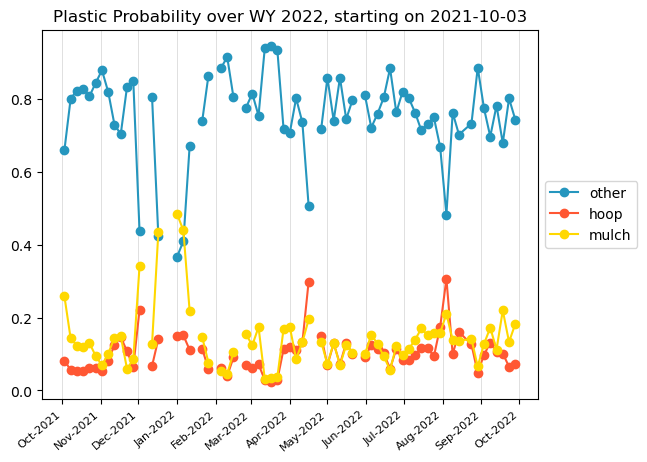

In [58]:
# Convert the date column to datetime values
df['dateT'] = pd.to_datetime(df['date'])

# line chart layered with points for clarity
wy_title = first_date.year + 1
plt.title(f"Plastic Probability over WY {wy_title}, starting on {first_date.date()}")
plt.plot(df['dateT'], df['other'], '-o', color='#2596be', label='other')
plt.plot(df['dateT'], df['hoop'], '-o', color='#FF5733', label='hoop')
plt.plot(df['dateT'], df['mulch'], '-o', color='#ffd800', label='mulch')
plt.legend(loc='center left', bbox_to_anchor=(1, 0.5))
plt.grid(axis='x', color='lightgray', linestyle='-', linewidth=0.5)
# plt.axhline(y=0.5, color='yellow', linestyle='--', linewidth=1) # lines to show the threshold for plastic
# plt.axhline(y=0.6, color='red', linestyle='--', linewidth=1)

# Set x-axis to show only month-year labels
plt.gca().xaxis.set_major_locator(mdates.MonthLocator())
plt.gca().xaxis.set_major_formatter(mdates.DateFormatter('%b-%Y'))

plt.xticks(rotation=40, ha='right', fontsize=8)
plt.show()


In [59]:
# just a line chart
# df.plot(x='date', y=['hoop', 'mulch', 'other'], kind='line', color=['#FF5733', '#F4F31D', '#2596be'])

# line chart layered with points for clarity
# plt.plot(df['date'], df['other'], '-o', color='#2596be', label='other')
# plt.plot(df['date'], df['hoop'], '-o', color='#FF5733', label='hoop')
# plt.plot(df['date'], df['mulch'], '-o', color='#F4F31D', label='mulch')
# plt.legend(loc='center left', bbox_to_anchor=(1, 0.5))
# plt.xticks(df['date'][::2], rotation=75, ha='right', fontsize=8)
# plt.show()

##### can test if the region updated appropriately

In [60]:
# m = geemap.Map()
# m.add_basemap('HYBRID')
# m.addLayer(classified_timeseries.first(), {}, 'Classified Probabilities')
# m.addLayer(region, {}, 'Region')
# m.centerObject(region, 13)
# m

## 8. Classify all images in a year across CA/one county

In [61]:
# grab all sentinel images in a time period (cloud filtered)
# set the water year and county of interest
wy = 2024
county = santabarbara # ventura, mendo, cruz, santabarbara, sanbenito, humboldt
# get text name of county
county_name = county.first().get('NAME').getInfo().replace(" ", "")

# # for exporting across the county line in watsonville
# wats_region = ee.FeatureCollection('projects/ee-tnc-annietaylor/assets/agplastics/watsonville_region').first()
# county = wats_region.geometry() 
# county_name = 'Watsonville'  

# create dates
stdate = f'{wy-1}-10-01'
endate = f'{wy}-10-01' # end date is exclusive

# ~24 images per day across CA, ~169 images to cover CA over 5 days
# ~256 images per year in santa cruz county
sentinel_ts = processedCollection.filterDate(stdate, endate).filterBounds(county) #if statewide, comment out filterBounds
print(f'Plastic classification for {county_name} County in water year {wy}')
# if statewide, use this line instead
# print(f'Plastic classification for the state of California in water year {wy}')
print('Number of images: ', sentinel_ts.size().getInfo())

# then add corresponding ET data for each month (map over collection)
def add_ET(image):
    image_sts = image.get('system:time_start')
    date = image.date()
    et_date = ee.Date(ee.Date(date).format('yyyy-MM-01')) #convert to first of month for ET data
    et_img = et.filterDate(et_date, et_date.advance(1, 'month')).median().rename('ET')
    return image.addBands(et_img).set('system:time_start', image_sts)

sentinel_ts_ET = sentinel_ts.map(add_ET)

# then classify each image (map over collection)
def classify_image_2(image):
    image_sts = image.get('system:time_start') # enables filterDate functionality
    date = image.get('date')
    classified_multi = image.classify(trained_prob_RF).updateMask(crops)
    probabilities = classified_multi.arrayFlatten([['hoop', 'mulch', 'other']])
    return probabilities.set('date', date).set('system:time_start', image_sts)

classified_timeseries = sentinel_ts_ET.map(classify_image_2)

Plastic classification for SantaBarbara County in water year 2024
Number of images:  752


#### Get top percentile value

In [62]:
# create a mosaic for one day and add to map for testing

# either by testing a date
# date = '2022-01-20'
# nextday = ee.Date(date).advance(1, 'day').format('YYYY-MM-dd')
# classified = classified_timeseries.filterDate(date, nextday).median()

# or taking the entire collection
# count = sentinel_ts.count()
classified = classified_timeseries.reduce(ee.Reducer.percentile([95])).select(['hoop_p95', 'mulch_p95'])
# classifiedmask = classified.gt(0.75)
sentinel_image = sentinel_ts.median()

# add to map
# ca_outline = ee.FeatureCollection(ca).style(fillColor='00000000')
# m = geemap.Map()
# m.add_basemap('HYBRID')
# m.addLayer(sentinel_image, rgbVis, 'Cloudless Sentinel', False)
# m.addLayer(classified, {}, 'Classified Probabilities', False)
# m.addLayer(count, {'min': 0, 'max': 75}, 'Number of Images')
# m.addLayer(ca_outline, {}, 'California')
# m.centerObject(ca, 6)
# m

#### Comparing the two bands to get integrated raster
i.e. if a pixel is classified as mulch and hoop, use difference from threshold to determine which class it is

In [63]:
def integrate_classes(image):
    # Define my thresholds for each band
    bh_th = 0.6
    bm_th = 0.5

    # Define the two bands you want to compare
    # input image is classified, has a hoop_p95 and mulch_p95 band
    bh = image.select('hoop_p95')
    bm = image.select('mulch_p95')

    # difference from threshold for each
    bh_diff = bh.subtract(bh_th).rename('bh_diff')
    bm_diff = bm.subtract(bm_th).rename('bm_diff')

    class_band = image.expression(
        # "bh_gt >= 0 ? 1 : (bm_gt >= 0 ? 2 : 0)", # super simple version
        # if bh if gte threshold, class = 1 (hoop)
        # if bm if gte threshold, class = 2 (mulch)
        # if bh and bm are both under threshold, class = 0 (other)
        # this is the more complex version that takes into account the difference from the threshold
        # if bh_diff = bm_diff, classify it as hoop (1)
        "(bh_diff >= 0 && (bm_diff < 0 || bh_diff >= bm_diff)) ? 1 : ((bm_diff >= 0 && (bh_diff < 0 || bm_diff > bh_diff)) ? 2 : 0)",
        {
            # 'bh_gt': bh_gt, # these are 0 or 1
            # 'bm_gt': bm_gt, # 0 or 1
            'bh_diff': bh_diff,
            'bm_diff': bm_diff
        }
    ).rename('class')
    return image.addBands(class_band)

classified_integrated = integrate_classes(classified)
# if statewide, comment out clip below
classes = classified_integrated.select('class').updateMask(crops).clip(county)

# Add the results to the map
# m = geemap.Map()
# m.addLayer(classified, {}, 'Classified Probabilities', False)
# m.addLayer(classes, {'min': 0, 'max': 2, 'palette': ['blue', 'red', 'yellow']}, 'Final Classes')
# m.centerObject(ventura, 6)
# m

#### Calculate num/area of pixels classified as both

In [64]:
# def integrate_classes(image):
#     # Define my thresholds for each band
#     bh_th = 0.6
#     bm_th = 0.5

#     # Define the two bands you want to compare
#     # input image is classified, has a hoop_p95 and mulch_p95 band
#     bh = image.select('hoop_p95')
#     bm = image.select('mulch_p95')

#     # difference from threshold for each
#     bh_diff = bh.subtract(bh_th).rename('bh_diff')
#     bm_diff = bm.subtract(bm_th).rename('bm_diff')

#     class_band = image.expression(
#         # if both are below threshold, class = 0 (other)
#         # if it's bh_diff >= 0 and bm_diff < 0, it's hoop = 1
#         # if it's bm_diff >= 0 and bh_diff < 0, it's mulch = 2
#         # if it's bh_diff >= 0 and bm_diff >= 0, then compare the two
#         #   if bh_diff > bm_diff, class = 3 (confident hoop)
#         #   if bm_diff > bh_diff, class = 4 (confident mulch)
#         "(bh_diff < 0 && bm_diff < 0) ? 0"  # both below threshold
#         " : (bh_diff >= 0 && bm_diff < 0) ? 1"  # hoop only
#         " : (bm_diff >= 0 && bh_diff < 0) ? 2"  # mulch only
#         " : (bh_diff > bm_diff) ? 3"            # both above, hoop more confident
#         " : 4",                                # both above, mulch more confident
#         {

#             'bh_diff': bh_diff,
#             'bm_diff': bm_diff
#         }
#     ).rename('class_confusion')
#     return image.addBands(class_band)

# classified_count = integrate_classes(classified)
# # if statewide, comment out clip below
# class_confusion = classified_count.select('class_confusion').updateMask(crops).clip(county)

# # Add the results to the map
# m = geemap.Map()
# m.addLayer(classified, {}, 'Classified Probabilities', False)
# m.addLayer(class_confusion, {'min': 0, 'max': 4, 'palette': ['blue', 'red', 'yellow', 'pink', 'orange']}, 'Classes with Confusion')
# m.centerObject(ventura, 6)
# m

#### Export the masked, unmasked probability image OR integrated image

In [65]:
# export integrated raster to asset
# export_task = ee.batch.Export.image.toAsset(
#     image=classes,
#     description=f'classes_image_{county_name}_{wy}',
#     assetId=f'projects/ee-tnc-annietaylor/assets/agplastics/PlasticClass_{county_name}Co_WY{wy}_v1_1',
#     region=county.geometry(),
#     scale=10,
#     maxPixels=1e13
# )
# export_task.start()

# export integrated raster to drive
export_task = ee.batch.Export.image.toDrive(
    # image=classified, #changed from classes to just classifeid to export probabilities
    image=classes, # this is the integrated class
    description=f'classes_image_{county_name}_{wy}',
    fileNamePrefix=f'PlasticClass_{county_name}Co_WY{wy}_v1_1',
    # fileNamePrefix=f'PlasticClass_{county_name}Co_AprMayJun{wy}_v1_1',
    folder='EarthEngine',
    region=county,#.geometry(),
    scale=10,
    maxPixels=1e13
)
# export_task.start()


# export integrated raster to asset
# export_ca = ee.batch.Export.image.toAsset(
#     image=classes,
#     description=f'classes_image_california_{wy}',
#     assetId=f'projects/ee-tnc-annietaylor/assets/agplastics/PlasticClass_CA_WY{wy}_v1_1',
#     region=ca.geometry(),
#     scale=10,
#     maxPixels=1e13
# )
# export_ca.start()


#### 8.1 Export all waters years for one county 

In [66]:
# county of interest
county = ventura # ventura, mendo, cruz, santabarbara, sanbenito, humboldt
# get text name of county
county_name = county.first().get('NAME').getInfo().replace(" ", "")

wys = [2019, 2020, 2021, 2022, 2023, 2024] 

for wy in wys:
    stdate = f'{wy-1}-10-01'
    endate = f'{wy}-10-01' # end date is exclusive
    sentinel_ts = processedCollection.filterDate(stdate, endate).filterBounds(county)
    print(f'Plastic classification for {county_name} County in water year {wy}. Images = ', sentinel_ts.size().getInfo())
    # add corresponding ET data for each month (map over collection)
    sentinel_ts_ET = sentinel_ts.map(add_ET)
    # then classify each image (map over collection)
    classified_timeseries = sentinel_ts_ET.map(classify_image_2)
    # get the 95 percentile values of that time series
    classified = classified_timeseries.reduce(ee.Reducer.percentile([95])).select(['hoop_p95', 'mulch_p95'])
    # combine hoop and mulch classes based on distance above respective thresholds
    classified_integrated = integrate_classes(classified)
    # mask to crops and clip to county
    classes = classified_integrated.select('class').updateMask(crops).clip(county)
    # export integrated raster to drive
    export_task = ee.batch.Export.image.toDrive(
        image=classes,
        description=f'classes_image_{county_name}_{wy}',
        fileNamePrefix=f'PlasticClass_{county_name}Co_WY{wy}_v1_1',
        folder='EarthEngine',
        region=county.geometry(),
        scale=30,
        maxPixels=1e13
    )
    export_task.start()
print('Exporting images to drive')

Plastic classification for Ventura County in water year 2019. Images =  513
Plastic classification for Ventura County in water year 2020. Images =  660
Plastic classification for Ventura County in water year 2021. Images =  655
Plastic classification for Ventura County in water year 2022. Images =  673
Plastic classification for Ventura County in water year 2023. Images =  609
Plastic classification for Ventura County in water year 2024. Images =  626
Exporting images to drive


#### 8.2 Export month combinations to make training data

In [67]:
# how many days centered around each training data point to include?
period = 366 # total days before + after the training data point to include in classification

# any period under 55 days will work on the fly
# or you can import assets for these periods: 60, 120, 240, 366

# Create a set of (location, date) pairs for training data I'm using
location_date_pairs = {
    ("Watsonville", "2023-04-12"),
    ("Oxnard", "2023-05-06"),
    ("Santa Maria", "2023-05-05"),
    ("Oxnard", "2022-10-01"),
    ("Oxnard", "2022-11-01"),
    ("Watsonville", "2022-09-11"),
}

# Function to filter the df based on location and date
def filter_by_location_date(location, date):
    df = all_data_test
    year_month = date[0:7]
    return df[(df['Location'] == location) & (df['Date'].str.startswith(year_month))]

def classify_plastic_at_location_date(location, date, period):
    # get the training points for that location and date
    filtered_data = filter_by_location_date(location, date)
    # print(f"{filtered_data.shape[0]} total training points in {location} on {date}")
    # get the county for that location
    if location == "Watsonville":
        county, county_name = cruz, 'Santa Cruz'
    elif location == "Oxnard":
        county, county_name = ventura, 'Ventura'
    elif location == "Santa Maria":
        county, county_name = santabarbara, 'Santa Barbara'
    else:
        print(f"Location {location} not recognized, need a county to filter by.")
    
    # get the start and end dates for the imagery 
    start_date = pd.to_datetime(date) - pd.Timedelta(days=period // 2)
    end_date = pd.to_datetime(date) + pd.Timedelta(days=(period // 2) +1) # adding 1 bc end date is exclusive

    # filter the timeseries collection for that location and date
    sentinel_ts = processedCollection.filterDate(start_date, end_date).filterBounds(county)
    # print(f'Classifying plastic in {county_name} County from {start_date.strftime('%Y-%m-%d')} to {end_date.strftime('%Y-%m-%d')}, period of {period} days')
    # print(f'Number of images = ', sentinel_ts.size().getInfo())
    # add corresponding ET data for each month
    sentinel_ts_ET = sentinel_ts.map(add_ET)
    # then classify each image (map over collection)
    classified_timeseries = sentinel_ts_ET.map(classify_image_2)
    # get the 95 percentile values of that time series
    classified = classified_timeseries.reduce(ee.Reducer.percentile([95])).select(['hoop_p95', 'mulch_p95'])
    # combine hoop and mulch classes based on distance above respective thresholds
    classified_integrated = integrate_classes(classified)
    # mask to crops and clip to county
    classes = classified_integrated.select('class').updateMask(crops).clip(county)
    # convert filtered_data DataFrame to an ee.FeatureCollection
    features = [
        ee.Feature(
            ee.Geometry.Point(row['Longitude'], row['Latitude']),
            {
                'Type': row['Type'],
                'Date': row['Date'],
                'Location': row['Location']
            }
        )
        for _, row in filtered_data.iterrows()
    ]
    points_fc = ee.FeatureCollection(features)
    # sample the classified image at those points
    sampled_points = classes.sampleRegions(
        collection=points_fc,
        scale=10
    )
    # return sampled_points
    # convert results to pandas df
    sampled_df = geemap.ee_to_df(sampled_points)
    # print(f"{sampled_df.shape[0]} training points sampled in {location} on {date} \n")
    # Map class values: 0 = other, 1 = hoop, 2 = mulch
    class_map = {0: 'other', 1: 'hoop', 2: 'mulch'}
    sampled_df['class'] = sampled_df['class'].map(class_map)
    return sampled_df
    # export the sampled points for each location/date to separate csv files
    # file_name = f"output/{location}_{date.replace('-', '')}_{period}day_period.csv"
    # sampled_df.to_csv(sampled_df, file_name, index=False)
    # print(f"Exported sampled points to {file_name}")

def extract_plastic_at_location_date(location, date, period):
    # useful for periods longer than 55 days, the function above times out
    # get the training points for that location and date
    filtered_data = filter_by_location_date(location, date)
    # print(f"{filtered_data.shape[0]} total training points in {location} on {date}")
    # get the county for that location
    if location == "Watsonville":
        county, county_name = cruz, 'SantaCruz'
    elif location == "Oxnard":
        county, county_name = ventura, 'Ventura'
    elif location == "Santa Maria":
        county, county_name = santabarbara, 'SantaBarbara'
    else:
        print(f"Location {location} not recognized, need a county to filter by.")
    # import relevant asset 
    classes = ee.Image(f'projects/ee-tnc-annietaylor/assets/agplastics/PlasticClass_{county_name}Co_{date.replace("-", "")}_{period}day_period_v1_1')
    # convert filtered_data DataFrame to an ee.FeatureCollection
    features = [
        ee.Feature(
            ee.Geometry.Point(row['Longitude'], row['Latitude']),
            {
                'Type': row['Type'],
                'Date': row['Date'],
                'Location': row['Location']
            }
        )
        for _, row in filtered_data.iterrows()
    ]
    points_fc = ee.FeatureCollection(features)
    # sample the classified image at those points
    sampled_points = classes.sampleRegions(
        collection=points_fc,
        scale=10
    )
    # return sampled_points
    # convert results to pandas df
    sampled_df = geemap.ee_to_df(sampled_points)
    # print(f"{sampled_df.shape[0]} training points sampled in {location} on {date} \n")
    # Map class values: 0 = other, 1 = hoop, 2 = mulch
    class_map = {0: 'other', 1: 'hoop', 2: 'mulch'}
    sampled_df['class'] = sampled_df['class'].map(class_map)
    return sampled_df

def combine_sampled_data(location_date_pairs, period):
    # Combine sampled data for multiple location-date pairs into a single df
    all_dfs = [] 
    for location, date in location_date_pairs:
        # df = classify_plastic_at_location_date(location, date, period) # on the fly for shorter periods
        df = extract_plastic_at_location_date(location, date, period) # pulls from asset for longer periods
        all_dfs.append(df)
    return pd.concat(all_dfs, ignore_index=True)


# def combined_sampled_fc(location_date_pairs, period):
#     # Combine sampled data for multiple location-date pairs into a single FeatureCollection
#     all_features = ee.FeatureCollection()
#     for location, date in location_date_pairs:
#         sampled_points = classify_plastic_at_location_date(location, date, period)
#         all_features.merge(sampled_points)
#     return ee.FeatureCollection(all_features)
    
# all_sampled_data = combined_sampled_fc(location_date_pairs, period)


# this part actually runs something, not just fn set up
# all_sampled_data = combine_sampled_data(location_date_pairs, period)

# # export the combined sampled data to a csv file
# output_file = f"output/validation_data_{period}day_period.csv"
# all_sampled_data.to_csv(output_file, index=False)
# print(f"Exported all sampled data to {output_file}")


##### Run this workflow on a list of period values, and compare total and class accuracy values

In [68]:
# all_sampled_data = combine_sampled_data(location_date_pairs, period)
period = 60
all_sampled_data = pd.read_csv(f'output/validation_data_{period}day_period.csv')
all_sampled_data

def accuracy_assessment(all_sampled_data):
    # Calculate the accuracy of the classification
    cm = confusion_matrix(all_sampled_data['Type'], all_sampled_data['class'], labels=['hoop', 'mulch', 'other'])
    accuracy = np.trace(cm) / np.sum(cm)
    # Save overall accuracy and class accuracies to a new df
    class_accuracies = [cm[i, i] / np.sum(cm[i, :]) for i in range(len(['hoop', 'mulch', 'other']))]
    acc_df = pd.DataFrame({
        'class': ['overall', 'hoop', 'mulch', 'other'],
        'accuracy': [accuracy] + class_accuracies
    })
    return acc_df

def accuracy_assessment_szn(all_sampled_data):
    # Calculate the accuracy of the classification for each season
    seasons = {
        'Spring': ['03', '04', '05'],
        'Summer': ['06', '07', '08'],
        'Fall': ['09', '10', '11'],
        'Winter': ['12', '01', '02']
    }
    results = []
    for season, months in seasons.items():
        # Compare months to the [5:7] index of the date string to get the season
        season_data = all_sampled_data[all_sampled_data['Date'].str[5:7].isin(months)]
        if not season_data.empty:
            cm = confusion_matrix(season_data['Type'], season_data['class'], labels=['hoop', 'mulch', 'other'])
            accuracy = np.trace(cm) / np.sum(cm)
            class_accuracies = [cm[i, i] / np.sum(cm[i, :]) for i in range(len(['hoop', 'mulch', 'other']))]
            results.append({
                'season': season,
                'overall_accuracy': accuracy,
                'hoop_accuracy': class_accuracies[0],
                'mulch_accuracy': class_accuracies[1],
                'other_accuracy': class_accuracies[2]
            })
    return pd.DataFrame(results)

print(accuracy_assessment_szn(all_sampled_data))

# # confusion matrix compare actual (type) to predicted (class_april23)
# cm = confusion_matrix(all_sampled_data['Type'], all_sampled_data['class'], labels=['hoop', 'mulch', 'other'])
# # Plot the confusion matrix using seaborn heatmap
# plt.figure(figsize=(8, 6))
# sns.heatmap(cm, annot=True, fmt='d', cmap='Blues', xticklabels=['hoop', 'mulch', 'other'], yticklabels=['hoop', 'mulch', 'other'])
# plt.title('Confusion Matrix')
# plt.xlabel('Predicted')
# plt.ylabel('Actual')
# plt.show()
# accuracy = np.trace(cm) / np.sum(cm)

# print(f'{all_sampled_data.shape[0]} training points')
# print(f'Overall accuracy: {accuracy:.2f}')
# # print the accuracy for each class
# for i, label in enumerate(['hoop', 'mulch', 'other']):
#     class_accuracy = cm[i, i] / np.sum(cm[i, :])
#     print(f'{label} accuracy: {class_accuracy:.2f}')

   season  overall_accuracy  hoop_accuracy  mulch_accuracy  other_accuracy
0  Spring          0.786992       0.922481        0.761404        0.746725
1    Fall          0.902041       0.993103        0.918216        0.671053


#### Plot accuracy vs period by season

season  overall_accuracy  hoop_accuracy  mulch_accuracy  other_accuracy  \
0   Spring          0.822764       0.825581        0.778947        0.839884   
1     Fall          0.836735       0.758621        0.881041        0.828947   
2   Spring          0.826016       0.848837        0.792982        0.831150   
3     Fall          0.885714       0.972414        0.892193        0.697368   
4   Spring          0.806504       0.910853        0.771930        0.781659   
5     Fall          0.904082       0.993103        0.918216        0.684211   
6   Spring          0.786992       0.922481        0.761404        0.746725   
7     Fall          0.902041       0.993103        0.918216        0.671053   
8   Spring          0.847154       0.899225        0.901754        0.804949   
9     Fall          0.906122       0.993103        0.944238        0.605263   
10  Spring          0.866667       0.922481        0.922807        0.822416   
11    Fall          0.906122       0.986207        0.933086        0.657895   
12  Spring          0.880488       0.918605        0.954386        0.835517   
13    Fall          0.895918       0.979310        0.925651        0.631579   

    period  
0       16  
1       16  
2       30  
3       30  
4       50  
5       50  
6       60  
7       60  
8      120  
9      120  
10     240  
11     240  
12     366  
13     366

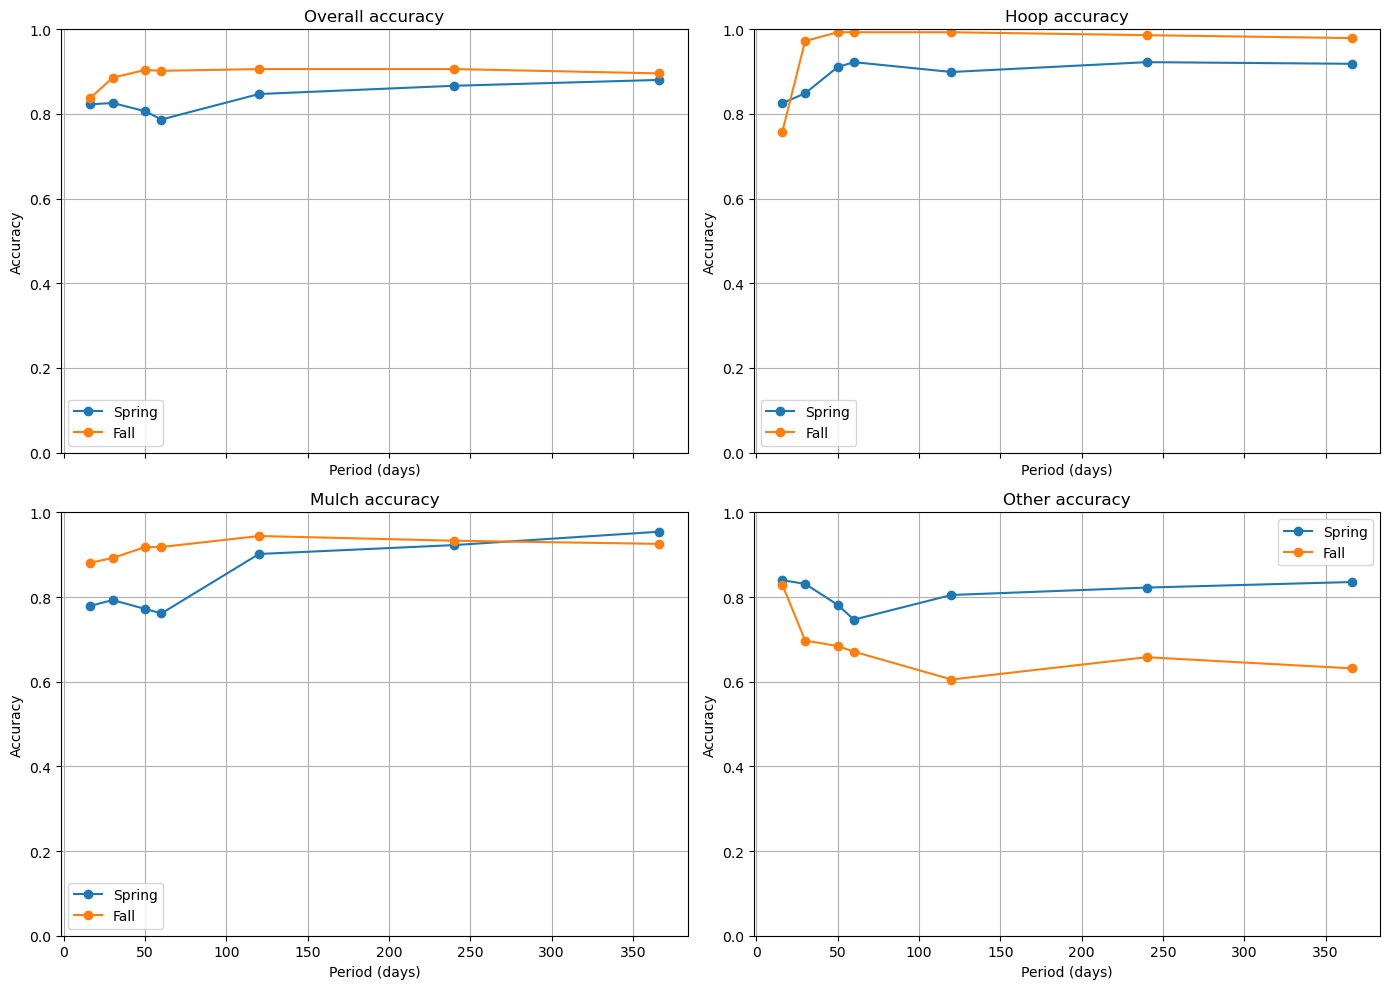

In [69]:
all_dfs = []

for x in [16, 30, 50, 60, 120, 240, 366]: #have to add to this as I export more data
    file = f"output/validation_data_{x}day_period.csv"
    df = pd.read_csv(file)
    acc_df = accuracy_assessment_szn(df)
    acc_df['period'] = x
    all_dfs.append(acc_df)

df = pd.concat(all_dfs, ignore_index=True)

display(df)

metrics = ['overall_accuracy', 'hoop_accuracy', 'mulch_accuracy', 'other_accuracy']
seasons = df['season'].unique()

fig, axs = plt.subplots(2, 2, figsize=(14, 10), sharex=True)
axs = axs.flatten()

for idx, metric in enumerate(metrics):
    ax = axs[idx]
    for season in seasons:
        season_df = df[df['season'] == season]
        ax.plot(season_df['period'], season_df[metric], marker='o', label=season)
    ax.set_title(metric.replace('_', ' ').capitalize())
    ax.set_xlabel('Period (days)')
    ax.set_ylabel('Accuracy')
    ax.set_ylim(0, 1)
    ax.legend()
    ax.grid(True)

plt.tight_layout()
plt.show()

##### Plot accuracy vs period
Using existing exported csvs, see code block right under 8.2

class   overall      hoop     mulch     other  period
0      0.826744  0.801489  0.828520  0.838794      16
1      0.843023  0.893300  0.841155  0.817824      30
2      0.834302  0.940447  0.842960  0.771953      50
3      0.819767  0.947891  0.837545  0.739187      60
4      0.863953  0.933002  0.922383  0.785059     120
5      0.877907  0.945409  0.927798  0.806029     240
6      0.884884  0.940447  0.940433  0.815203     366

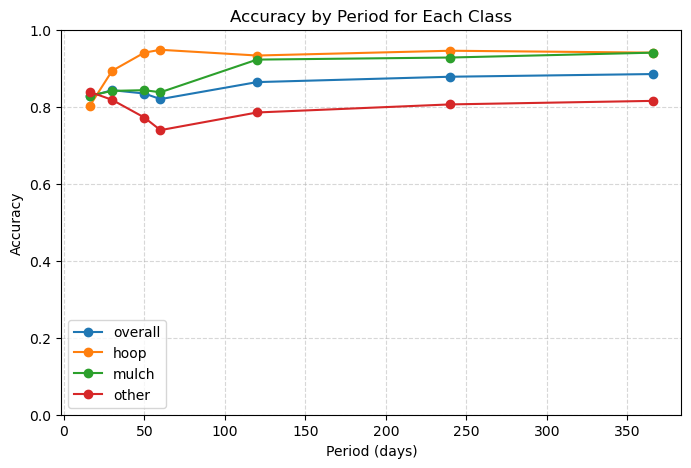

In [70]:
all_dfs = []

for x in [16, 30, 50, 60, 120, 240, 366]: #have to add to this as I export more data
    file = f"output/validation_data_{x}day_period.csv"
    df = pd.read_csv(file)
    acc_df = accuracy_assessment(df)
    # transpose the df
    acc_df = acc_df.set_index('class').T
    acc_df['period'] = x
    all_dfs.append(acc_df)

df = pd.concat(all_dfs, ignore_index=True)
display(df)

plt.figure(figsize=(8, 5))
fields = ['overall', 'hoop', 'mulch', 'other']
for field in fields:
    plt.plot(df['period'], df[field], marker='o', label=field)
plt.xlabel('Period (days)')
plt.ylabel('Accuracy')
plt.title('Accuracy by Period for Each Class')
plt.ylim(0, 1)
plt.legend()
plt.grid(True, linestyle='--', alpha=0.5)
plt.show()

##### Export images to asset for validation data
This is needed for the periods greater than ~55 days. Once exported, you can run code above to get csvs exported, then imported into the chart. 

In [71]:
period = 366

location_date_pairs = {
    ("Watsonville", "2023-04-12"),
    ("Oxnard", "2023-05-06"),
    ("Santa Maria", "2023-05-05"),
    ("Oxnard", "2022-10-01"),
    ("Oxnard", "2022-11-01"),
    ("Watsonville", "2022-09-11"),
}

def export_plastic_at_location_date(location, date, period):
    # get the county for that location
    if location == "Watsonville":
        county, county_name = cruz, 'Santa Cruz'
    elif location == "Oxnard":
        county, county_name = ventura, 'Ventura'
    elif location == "Santa Maria":
        county, county_name = santabarbara, 'Santa Barbara'
    else:
        print(f"Location {location} not recognized, need a county to filter by.")
    
    # get the start and end dates for the imagery 
    start_date = pd.to_datetime(date) - pd.Timedelta(days=period // 2)
    end_date = pd.to_datetime(date) + pd.Timedelta(days=(period // 2) +1) # adding 1 bc end date is exclusive

    # filter the timeseries collection for that location and date
    sentinel_ts = processedCollection.filterDate(start_date, end_date).filterBounds(county)
    # print(f'Classifying plastic in {county_name} County from {start_date.strftime('%Y-%m-%d')} to {end_date.strftime('%Y-%m-%d')}, period of {period} days')
    # print(f'Number of images = ', sentinel_ts.size().getInfo())
    # add corresponding ET data for each month
    sentinel_ts_ET = sentinel_ts.map(add_ET)
    # then classify each image (map over collection)
    classified_timeseries = sentinel_ts_ET.map(classify_image_2)
    # get the 95 percentile values of that time series
    classified = classified_timeseries.reduce(ee.Reducer.percentile([95])).select(['hoop_p95', 'mulch_p95'])
    # combine hoop and mulch classes based on distance above respective thresholds
    classified_integrated = integrate_classes(classified)
    # mask to crops and clip to county
    classes = classified_integrated.select('class').updateMask(crops).clip(county)
    county_name = county_name.replace(" ", "")
    filename = f'PlasticClass_{county_name}Co_{date.replace("-", "")}_{period}day_period_v1_1'
    # export to asset
    export_task = ee.batch.Export.image.toAsset(
        image=classes,
        description=filename,
        assetId=f'projects/ee-tnc-annietaylor/assets/agplastics/{filename}',
        region=county.geometry(),
        scale=10,
        maxPixels=1e13
    )
    export_task.start()
    print(f'Exporting {filename} to asset')

# Exports five assets per period selected
# for location, date in location_date_pairs:
#     export_plastic_at_location_date(location, date, period)

#### 8.3 Export in batches to cover CA
Have to update code above to be ca instead of county, and uses that water year

Pulling from https://spatialthoughts.com/2024/10/23/large-image-exports-gee/

In [66]:
ca_geom = ca.geometry()

# Export CRS
crs = 'EPSG:3310'  # California Albers m

# Pixel size for export (meters)
pixelSize = 10

# Export tile size (pixels) - ideal to keep under 10,000 x 10,000 pixel limit
# tileSize = 10000
tileSize = 20000

# Calculate the grid size (meters)
gridSize = tileSize * pixelSize

# Create the grid covering the geometry bounds
bounds = ca_geom.bounds(**{
  'proj': crs, 'maxError': 1
})

grid = bounds.coveringGrid(**{
  'proj':crs, 'scale': gridSize
})
m = geemap.Map(width=800)
# m.addLayer(classes, {}, 'Classification Image')
m.centerObject(ca, 5)
m.addLayer(grid, {'color': 'blue'}, 'Grid')
# with tileSize 10000, this is 120 images, which isn't a great solution
# with tileSize 20000, this is 35 images -- not sure if this will export though

# this filtered grid is for the tileSize = 15000
# grid_filt = grid.filter(
#     ee.Filter.inList('system:index', tile_ids[0:11] + tile_ids[14:16] + tile_ids[-7:])
# )

# get grid tile IDs
tile_ids = grid.aggregate_array('system:index').getInfo()
# filter first to intersecting with the ca geom
grid_filt = grid.filterBounds(ca_geom)
# then filter out tiles that barely intersect with the ca geom
grid_filt = grid_filt.filter( # these indices are specific to the tileSize = 20000
    ee.Filter.inList('system:index', [tile_ids[3], tile_ids[6], tile_ids[27], tile_ids[32]]).Not()
)

m.addLayer(grid_filt, {'color': 'pink'}, 'Grid Filtered')
m.addLayer(ca_geom, {'color': 'red'}, 'California Geometry')
m

Map(center=[37.152434104671315, -119.52655155150876], controls=(WidgetControl(options=['position', 'transparen…

##### Calculate the CRS transform for export

In [67]:
# Calculate the coordinates of the top-left corner of the grid
bounds = grid.geometry().bounds(**{
  'proj': crs, 'maxError': 1
})

# Extract the coordinates of the grid
coordList = ee.Array.cat(bounds.coordinates(), 1)
xCoords = coordList.slice(1, 0, 1)
yCoords = coordList.slice(1, 1, 2)

# Get the coordinates of the top-left pixel
xMin = xCoords.reduce('min', [0]).get([0,0])
yMax = yCoords.reduce('max', [0]).get([0,0])

# Create the CRS Transform
# The transform consists of 6 parameters:
# [xScale, xShearing, xTranslation, yShearing, yScale, yTranslation]
transform = ee.List([pixelSize, 0, xMin, 0, -pixelSize, yMax]).getInfo()
print(transform)

# Assign a no-data value
noDataValue = 0
classes_unmasked = classes.unmask(**{
    'value':noDataValue,
    'sameFootprint': False
})

[10, 0, -400000, 0, -10, 600000]


##### Export tiles for CA

In [68]:
# # commenting this out for now so that nothing runs
# # lets try exporting one of the tiles
# tile_ids_filt = grid_filt.aggregate_array('system:index').getInfo()
# print('Total tiles', len(tile_ids_filt))

# tile_ids_filt = tile_ids_filt[0:1] # just for testing, export one tile

# # Exporting all tiles from list to google drive
# for i, tile_id in enumerate(tile_ids_filt):
#     feature = ee.Feature(grid_filt.toList(3, i).get(0))
#     # display(grid_filt.toList(3, i).get(0))
#     geometry = feature.geometry()
#     task_name = f'Plastic_CA_WY{wy}_tile_' + tile_id.replace(',', '_') + 'v1_1'
#     task = ee.batch.Export.image.toDrive(**{
#         'image': classes_unmasked,
#         'description': f'Export_{task_name}',
#         'fileNamePrefix': task_name,
#         'folder':'EarthEngine',
#         'crs': crs,
#         'crsTransform': transform,
#         'region': geometry,
#         'maxPixels': 1e13
#     })
#     task.start()
#     print(f'Started Task to export tile {tile_id}, export #{i+1}')
# # grid_filt
# # tile_ids_filt

### 8.5 Thresholding - extract WY values to validation points


#### split into EE water years

In [69]:
# # set which water years you need
# wys = [2019, 2020, 2021, 2022, 2023]

# # initialize an empty image
# wys_all = ee.Image()

# for wy in wys:
#     stdate = f'{wy-1}-10-01'
#     endate = f'{wy}-09-30'
#     mulch_label = f'mulch_wy{wy}'
#     hoop_label = f'hoop_wy{wy}'
#     wy_images = classified_timeseries.filterDate(stdate, endate).select(['hoop', 'mulch', 'other'])
#     wy_bands = wy_images.reduce(ee.Reducer.percentile([95])).select(['hoop_p95', 'mulch_p95']).rename([hoop_label, mulch_label])
#     wys_all = wys_all.addBands(wy_bands)
# wys_all

In [70]:
# # gonna try exporting it to an asset
# export_task = ee.batch.Export.image.toAsset(
#     image=wys_all,
#     description='wats_wys',
#     assetId='projects/ee-tnc-annietaylor/assets/agplastics/SantaCruzCo_WYs_95p',
#     region=cruz.geometry(), #CHANGE THIS
#     scale=10,
#     maxPixels=1e13
# )
# export_task.start()

#### Export band values to training points using EE fn

In [71]:
# # sample hoop/mulch probability for each WY to all validation points
# wats_fcpts = geemap.df_to_ee(watsonville, latitude='Latitude', longitude='Longitude')
# wys_all = ee.Image('projects/ee-tnc-annietaylor/assets/agplastics/SantaCruzCo_WYs_95p')

# sampled_points = wys_all.sampleRegions(
#     collection=wats_fcpts,
#     scale=200 # ideally 10m
# )

# # Convert the sampled points to df
# sampled_points_df = geemap.ee_to_df(sampled_points)

# # Display the DataFrame
# print(sampled_points_df)


#### Export band values to training points in geopandas

In [72]:
# # Loop through all rasters and sample to the points for that region
# # watsonville:
# # df = watsonville
# # wys = [2020, 2021, 2022, 2023]
# # rasters = [
# #     'Plastic_SantaCruzCo_95p_WY2020.tif',
# #     'Plastic_SantaCruzCo_95p_WY2021.tif',
# #     'PlasticClass_SantaCruzCo_95p_WY2022.tif',
# #     'Plastic_SantaCruzCo_95p_WY2023.tif'
# # ]

# # df = oxnard
# # wys = [2019, 2020, 2021, 2022, 2023]
# # rasters = [
# #     'Plastic_VenturaCo_95p_WY2019.tif',
# #     'Plastic_VenturaCo_95p_WY2020.tif',
# #     'Plastic_VenturaCo_95p_WY2021.tif',
# #     'PlasticClass_venturaCo_95p_WY2022.tif',
# #     'Plastic_VenturaCo_95p_WY2023.tif'
# # ]

# df = santamaria
# wys = [2021, 2022, 2023]
# rasters = [
#     'Plastic_SBCo_95p_WY2021.tif',
#     'PlasticClass_santabarbaraCo_95p_WY2022.tif',
#     'Plastic_SBCo_95p_WY2023.tif'
# ]

# for wy, raster in zip(wys, rasters):
#     # src = rasterio.open(f'N:\OCEANS_Program\Plastics\Agricultural_Plastics\AgPlastics_Pro\EE_uploads_exports\Watsonville\\{raster}')
#     # src = rasterio.open(f'N:\OCEANS_Program\Plastics\Agricultural_Plastics\AgPlastics_Pro\EE_uploads_exports\Oxnard\\{raster}')
#     src = rasterio.open(f'N:\OCEANS_Program\Plastics\Agricultural_Plastics\AgPlastics_Pro\EE_uploads_exports\SantaMaria\\{raster}')
#     coord_list = [(x, y) for x, y in zip(df["Longitude"], df["Latitude"])]
#     df[[f'hoop_wy{wy}', f'mulch_wy{wy}']] = [a for a in src.sample(coord_list)]

# df.head()

#### Assign hoop & mulch fields to WY value based on training data date

In [73]:
# # First add a col with water year to the df
# # make a new col that is in datetime format
# df['pDate'] = pd.to_datetime(df['Date'])

# def add_WY(row):
#     if row['pDate'].month >= 10:
#         return row['pDate'].year + 1
#     else:
#         return row['pDate'].year

# df['WY'] = df.apply(add_WY, axis=1)

# # print(df['WY'].unique())

# # exclude 2018 since we don't have images for it
# # this will be different for each region
# # df = df[df['WY'] > 2018] # need for watsonville
# # df = df[df['WY'] < 2024] # need for oxnard
# df = df[df['WY'] > 2020] # need for santamaria

# # set the hoop field to be the corresponding hoop_wy{wy} value based on the WY field
# df['hoop'] = df.apply(lambda x: x[f'hoop_wy{x["WY"]}'], axis=1)
# df['mulch'] = df.apply(lambda x: x[f'mulch_wy{x["WY"]}'], axis=1)

# df.head()
# # df[df['WY'] == 2021].head(100)

#### Save to csv for easy import into threshold_determination script

In [74]:
# csv_name = train_path + 'Watsonville_val_BM_P95.csv'
# csv_name = train_path + 'Oxnard_all_P95.csv'
# csv_name = train_path + 'SantaMaria_val_o_P95.csv'
# df.to_csv(csv_name)
# when importing, drop 0 and null values

## 9. Area Calculations

### Reduce area to counties - integrated raster

In [75]:
# county = cruz
# wys = [2019, 2020, 2021, 2022, 2023]

# county_name = county.first().get('NAME').getInfo().replace(" ", "")

# # Create a pixel area image. Pixel values are square meters based on a given CRS and scale (or CRS transform).
pixel_area = ee.Image.pixelArea()
# # The default projection is WGS84 with 1-degree scale.
# # display('Pixel area default projection', pixel_area.projection())

# df_county_ts = []

# for wy in wys:
#     # import asset
#     ras = ee.Image(f'projects/ee-tnc-annietaylor/assets/agplastics/PlasticClass_{county_name}Co_WY{wy}_int_v2')
    
#     # reproject the raster (doesn't appear necessary, results identical) 
#     ras = ras.reproject(crs='EPSG:3310', scale=10)

#     hoop = ras.select('class').eq(1)
#     mulch = ras.select('class').eq(2) # TODO print these to map to double check

#     hoop_area = pixel_area.updateMask(hoop)
#     mulch_area = pixel_area.updateMask(mulch)

#     hoop_area_calc = hoop_area.reduceRegion(
#         reducer=ee.Reducer.sum(),
#         geometry=county.geometry(),
#         crs=ee.Projection('EPSG:3310'),
#         scale=10,
#         # crsTransform=ras2022.projection().getInfo()['transform'],
#         maxPixels=1e8,
#     )

#     mulch_area_calc = mulch_area.reduceRegion(
#         reducer=ee.Reducer.sum(),
#         geometry=county.geometry(),
#         crs=ee.Projection('EPSG:3310'),
#         scale=10,
#         # crsTransform=ras2022.projection().getInfo()['transform'],
#         maxPixels=1e8,
#     )

#     hoop_m2 = hoop_area_calc.getNumber('area').getInfo()
#     mulch_m2 = mulch_area_calc.getNumber('area').getInfo()

#     # save these numbers to a dataframe
#     data = {
#         'Year': [wy],
#         'County': [county_name],
#         'Hoop_m2': [hoop_m2],
#         'Hoop_acres': [(hoop_m2/4046.8564224)], # to convert m2 to acres
#         'Mulch_m2': [mulch_m2],
#         'Mulch_acres': [(mulch_m2/4046.8564224)]
#     }
#     df_county_ts.append(pd.DataFrame(data))

# df_area = pd.concat(df_county_ts)
# display(df_area)

# # display(f'Area of plastic mulch in {county_name} County in 2022 is {mulch_sqmeters_22.getInfo():.2f} m2 or {mulch_acres_22.getInfo():.2f} acres')
# # display(f'Area of hoop houses in {county_name} County in 2022 is {hoop_sqmeters_22.getInfo():.2f} m2 or {hoop_acres_22.getInfo():.2f} acres')
# # display(f'Area of {plastic_type} in 2023  m2: {square_meters_23.getInfo()}, acres: {acres_23.getInfo()}')

### Calculate acreage as percent of ag lands

In [76]:
all_ag = ee.Image('projects/ee-annalisertaylor/assets/TNC/agplastics/dwr_allyears')

# # clip to county
# county_ag = all_ag.clip(county)

# # reproject the raster
# county_ag = county_ag.reproject(crs='EPSG:3310', scale=10)

# # mask pixel area image to ag lands
# ag_area = pixel_area.updateMask(county_ag)

# ag_area_calc = ag_area.reduceRegion(
#     reducer=ee.Reducer.sum(),
#     geometry=county.geometry(),
#     crs=ee.Projection('EPSG:3310'),
#     scale=10,
#     # crsTransform=ras2022.projection().getInfo()['transform'],
#     maxPixels=1e8,
# )

# # extract area and add to a df
# ag_area_m2 = ag_area_calc.getNumber('area').getInfo()

# results = {
#     'County': county_name,
#     'Ag_m2': ag_area_m2,
#     'Ag_acres': (ag_area_m2/4046.8564224)
# }

# display(results)

# # add a column to df_area standardized by ag land area in that county
# df_area['Hoop_acres_percent'] = df_area['Hoop_acres'] / results['Ag_acres']
# df_area['Mulch_acres_percent'] = df_area['Mulch_acres'] / results['Ag_acres']
# df_area


In [77]:
# # save to a csv for import into a stacked chart
# csv_name = f'N:\OCEANS_Program\Plastics\Agricultural_Plastics\Area_by_County\plasticAreaOverTime_{county_name}County_v2.csv'
# # df_area.to_csv(csv_name, index=False)


### Plot plastic acreage over time - one county

In [78]:
# county_name = county_name.replace("Santa", "Santa ")
# # Plot the change in mulch_acres and hoop_acres over Year side by side
# fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(13, 5))

# # Plot for Mulch Acres
# ax1.plot(df_area['Year'], df_area['Mulch_acres'], marker='o', linestyle='-', color='orange')
# ax1.set_ylabel('Acres of Plastic Mulch')
# ax1.set_title(f'Plastic Mulch Acreage in {county_name} County')
# ax1.set_xticks(df_area['Year'])  # Set x-axis ticks to be the integer values of the year

# # Plot for Hoop Acres
# ax2.plot(df_area['Year'], df_area['Hoop_acres'], marker='o', linestyle='-', color='darkred')
# ax2.set_ylabel('Acres of Hoop Houses')
# ax2.set_title(f'Hoop House Acreage in {county_name} County')
# ax2.set_xticks(df_area['Year'])  # Set x-axis ticks to be the integer values of the year

# plt.show()

### Plot plastic percent of acreage over time

In [79]:
# # Plot the change in mulch_acres_percent and hoop_acres_percent over year side by side
# fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(13, 5))

# # Plot for Mulch Acres
# ax1.plot(df_area['Year'], df_area['Mulch_acres_percent'], marker='o', linestyle='-', color='orange')
# ax1.set_ylabel('Plastic Mulch Coverage of Ag Land (%)')
# ax1.set_title(f'Plastic Mulch % Coverage in {county_name} County')
# ax1.set_xticks(df_area['Year'])  # Set x-axis ticks to be the integer values of the year

# # Plot for Hoop Acres
# ax2.plot(df_area['Year'], df_area['Hoop_acres_percent'], marker='o', linestyle='-', color='darkred')
# ax2.set_ylabel('Hoop House Coverage of Ag Land (%)')
# ax2.set_title(f'Hoop House % Coverage in {county_name} County')
# ax2.set_xticks(df_area['Year'])  

# plt.show()

### Area charts - import csvs with area calculations

In [5]:
# import all three csvs and combine into one df
# df_sb = pd.read_csv('N:\OCEANS_Program\Plastics\Agricultural_Plastics\Area_by_County\plasticAreaOverTime_SantaBarbaraCounty.csv')
# df_vt = pd.read_csv('N:\OCEANS_Program\Plastics\Agricultural_Plastics\Area_by_County\plasticAreaOverTime_VenturaCounty.csv')
# df_sc = pd.read_csv('N:\OCEANS_Program\Plastics\Agricultural_Plastics\Area_by_County\plasticAreaOverTime_SantaCruzCounty.csv')

df_sb = pd.read_csv(r'N:\OCEANS_Program\Plastics\Agricultural_Plastics\Area_by_County\plasticAreaOverTime_SantaBarbaraCounty_v2.csv')
df_vt = pd.read_csv(r'N:\OCEANS_Program\Plastics\Agricultural_Plastics\Area_by_County\plasticAreaOverTime_VenturaCounty_v2.csv')
df_sc = pd.read_csv(r'N:\OCEANS_Program\Plastics\Agricultural_Plastics\Area_by_County\plasticAreaOverTime_SantaCruzCounty_v2.csv')

df_all = pd.concat([df_sb, df_vt, df_sc])
df_all['Hoop_acres_percent'] *= 100 #adjusting this for plotting
df_all['Mulch_acres_percent'] *= 100
df_all['County_Name'] = df_all['County'].str.replace('Santa', 'Santa ')
# df_all.to_csv('N:\OCEANS_Program\Plastics\Agricultural_Plastics\Area_by_County\plasticAreaOverTime_allCounties_v2.csv', index=False)

#### Stacked area charts - counties side by side

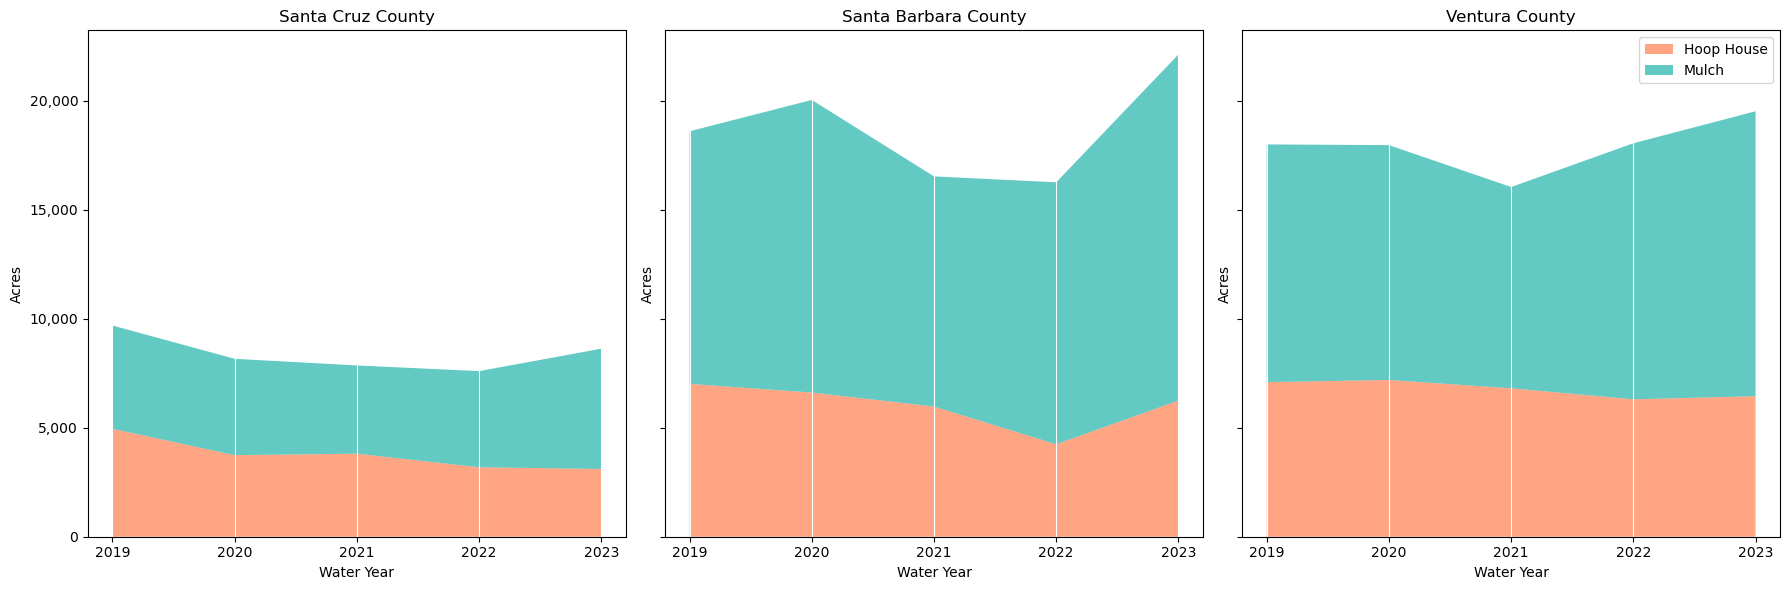

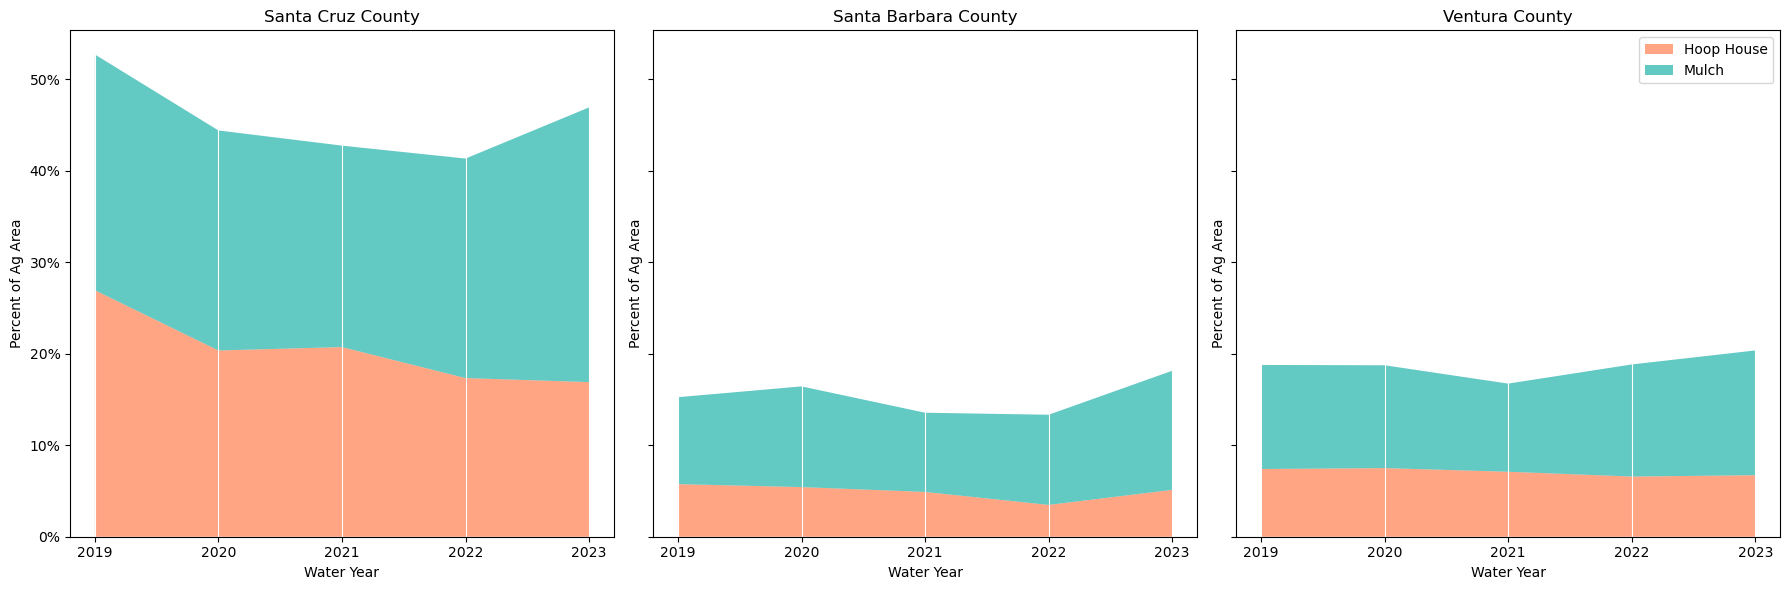

In [6]:
# iterate through the three counties' dataframes to plot them
df_list = [df_sc, df_sb, df_vt] # in order N to S

fig, axes = plt.subplots(1, 3, figsize=(18, 6), sharey=True)

for ax, df in zip(axes, df_list):
    location = df['County'].unique()[0].replace('Santa', 'Santa ')
    ax.stackplot(df['Year'], df['Hoop_acres'], df['Mulch_acres'], labels=['Hoop House', 'Mulch'], colors=['coral', 'lightseagreen'], alpha=0.7)
    ax.set_title(f'{location} County')
    ax.set_xlabel('Water Year')
    ax.set_xticks(df['Year'])
    ax.grid(axis='x', linestyle='-', color='white')
    ax.yaxis.set_major_formatter(mpl.ticker.StrMethodFormatter('{x:,.0f}'))
    ax.set_ylabel('Acres')
axes[2].legend()

plt.tight_layout()
plt.show()

fig, axes = plt.subplots(1, 3, figsize=(18, 6), sharey=True)

for ax, df in zip(axes, df_list):
    df['Hoop_acres_percent'] *= 100 #TODO just convert this at the creation stage, not here
    df['Mulch_acres_percent'] *= 100
    location = df['County'].unique()[0].replace('Santa', 'Santa ')
    ax.stackplot(df['Year'], df['Hoop_acres_percent'], df['Mulch_acres_percent'], labels=['Hoop House', 'Mulch'], colors=['coral', 'lightseagreen'], alpha=0.7)
    ax.set_title(f'{location} County')
    ax.set_xlabel('Water Year')
    ax.set_xticks(df['Year'])
    ax.grid(axis='x', linestyle='-', color='white')
    ax.yaxis.set_major_formatter(mpl.ticker.PercentFormatter())
    ax.set_ylabel('Percent of Ag Area')
axes[2].legend()

plt.tight_layout()
plt.show()

#### Stacked area charts - mulch and hoop split

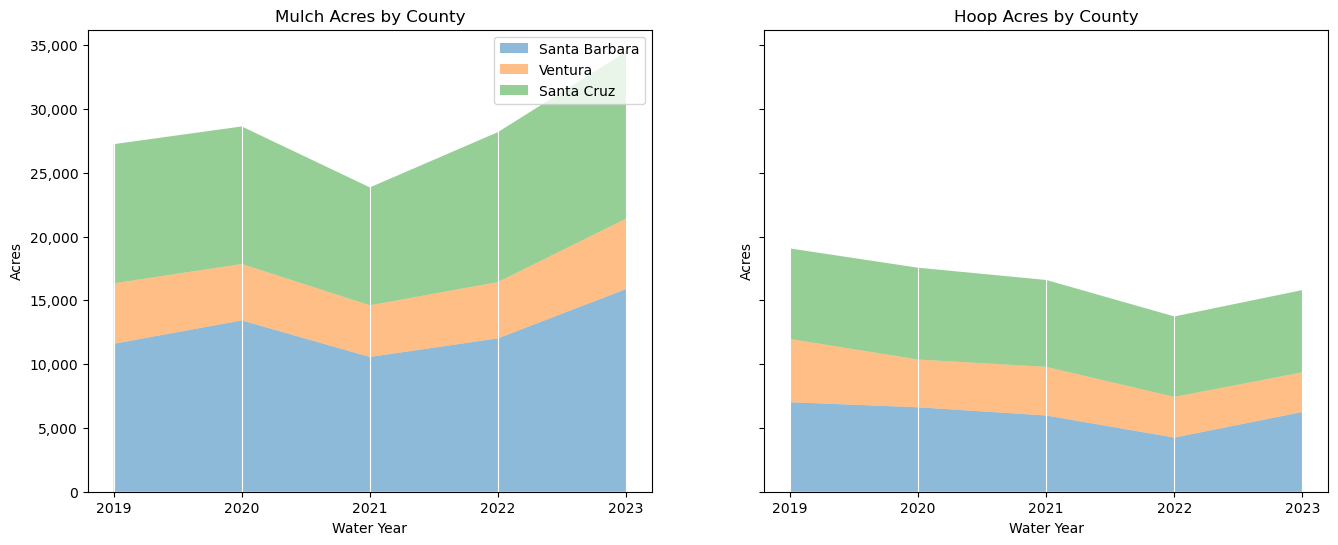

In [7]:
# create a stacked area chart with all three counties together using df_all
fig, axes = plt.subplots(1, 2, figsize=(16, 6), sharey=True)
# Add space after 'Santa' in the County column for display

ax1, ax2 = axes
# Create the stacked area chart for Hoop Acres
ax1.stackplot(df_all['Year'].unique(), df_all.pivot(index='Year', columns='County_Name', values='Mulch_acres').fillna(0).T, labels=df_all['County_Name'].unique(), alpha=0.5)
ax1.set_title('Mulch Acres by County')
ax1.set_xlabel('Water Year')
ax1.set_ylabel('Acres')
ax1.set_xticks(df['Year'])
ax1.grid(axis='x', linestyle='-', color='white')
ax1.yaxis.set_major_formatter(mpl.ticker.StrMethodFormatter('{x:,.0f}'))
ax1.legend()

# Create the stacked area chart for Mulch Acres
ax2.stackplot(df_all['Year'].unique(), df_all.pivot(index='Year', columns='County_Name', values='Hoop_acres').fillna(0).T, labels=df_all['County_Name'].unique(), alpha=0.5)
ax2.set_title('Hoop Acres by County')
ax2.set_xlabel('Water Year')
ax2.set_ylabel('Acres')
ax2.set_xticks(df['Year'])
ax2.grid(axis='x', linestyle='-', color='white')
ax2.yaxis.set_major_formatter(mpl.ticker.StrMethodFormatter('{x:,.0f}'))

#### Stacked area chart - all acres combined

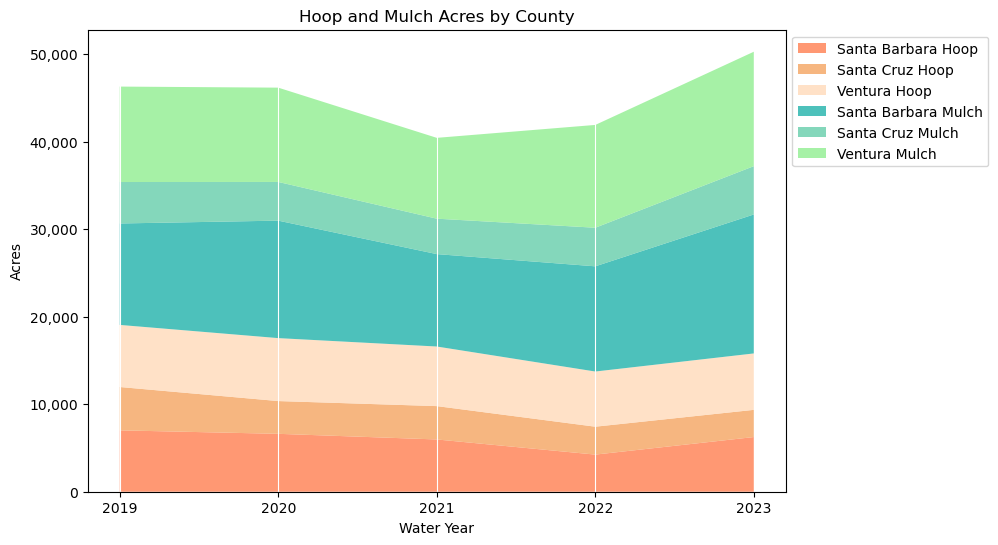

In [ ]:
# Create a stacked area chart with all three counties together using df_all
fig, ax = plt.subplots(figsize=(9, 6))

# Pivot the dataframe to get the data in the right format for stacking
pivot_df = df_all.pivot(index='Year', columns='County_Name', values=['Hoop_acres', 'Mulch_acres'])

color_map = ["coral", "sandybrown", "peachpuff", "lightseagreen", "mediumaquamarine", "lightgreen"]


# Plot the stacked area chart for Hoop and Mulch Acres
ax.stackplot(pivot_df.index, 
             pivot_df['Hoop_acres'].T, 
             pivot_df['Mulch_acres'].T, 
             labels=[f'{county} Hoop' for county in pivot_df['Hoop_acres'].columns] + [f'{county} Mulch' for county in pivot_df['Mulch_acres'].columns], 
             alpha=0.8,
             colors=color_map)

# Set the title and labels
ax.set_title('Hoop and Mulch Acres by County')
ax.set_xlabel('Water Year')
ax.set_ylabel('Acres')
ax.set_xticks(df_all['Year'].unique())
ax.legend(loc='upper left', bbox_to_anchor=(1, 1))
ax.grid(axis='x', linestyle='-', color='white')
ax.yaxis.set_major_formatter(mpl.ticker.StrMethodFormatter('{x:,.0f}'))

# export the plot as an svg for sara
# plt.savefig('N:/OCEANS_Program/Plastics/Agricultural_Plastics/Maps_Figures/Hoop_Mulch_Acres_by_County.svg', format='svg', bbox_inches='tight')

# Show the plot
plt.show()

#### Get total percent coverage across all counties

In [9]:
# Define the three counties
counties = [santabarbara, ventura, cruz]

# Initialize a list to store the results
results_list = []

# Loop through each county and calculate the agricultural area
for county in counties:
    # Get the county name
    county_name = county.first().get('NAME').getInfo()
    
    # Clip the all_ag image to the county
    county_ag = all_ag.clip(county)
    
    # Reproject the raster
    county_ag = county_ag.reproject(crs='EPSG:3310', scale=10)
    
    # Mask pixel area image to ag lands
    ag_area = pixel_area.updateMask(county_ag)
    
    # Calculate the area
    ag_area_calc = ag_area.reduceRegion(
        reducer=ee.Reducer.sum(),
        geometry=county.geometry(),
        crs=ee.Projection('EPSG:3310'),
        scale=10,
        maxPixels=1e8,
    )
    
    # Extract area in square meters and convert to acres
    ag_area_m2 = ag_area_calc.getNumber('area').getInfo()
    ag_area_acres = ag_area_m2 / 4046.8564224
    
    # Add the result to the list
    results_list.append({
        'County': county_name,
        'Ag_acres': ag_area_acres
    })

# Convert the list to a dataframe
df_ag_acres = pd.DataFrame(results_list)

# Display the dataframe
display(df_ag_acres)
total_ag_acres = df_ag_acres['Ag_acres'].sum()
display('Total ag acres across counties: ', total_ag_acres)

# Add a column to df_all standardized by total ag land area across all counties
df_all['Hoop_acres_percent_all'] = df_all['Hoop_acres'] / total_ag_acres * 100
df_all['Mulch_acres_percent_all'] = df_all['Mulch_acres'] / total_ag_acres * 100
# df_all


NameError: name 'santabarbara' is not defined

#### Stacked area chart - percent of total ag area combined

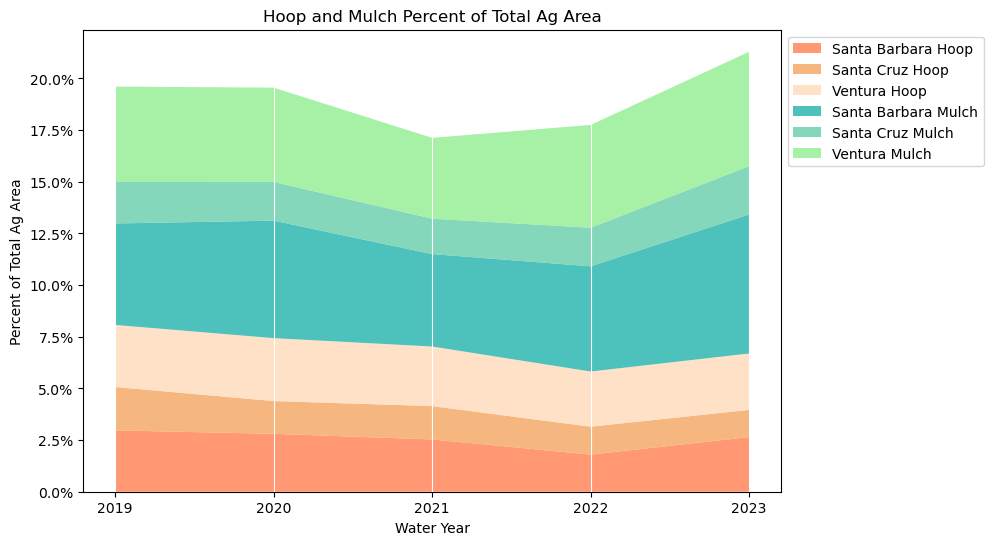

In [85]:
# Create a stacked area chart with all three counties together using df_all
fig, ax = plt.subplots(figsize=(9, 6))

# Pivot the dataframe to get the data in the right format for stacking
pivot_df = df_all.pivot(index='Year', columns='County_Name', values=['Hoop_acres_percent_all', 'Mulch_acres_percent_all'])

color_map = ["coral", "sandybrown", "peachpuff", "lightseagreen", "mediumaquamarine", "lightgreen"]


# Plot the stacked area chart for Hoop and Mulch Acres
ax.stackplot(pivot_df.index, 
             pivot_df['Hoop_acres_percent_all'].T, 
             pivot_df['Mulch_acres_percent_all'].T, 
             labels=[f'{county} Hoop' for county in pivot_df['Hoop_acres_percent_all'].columns] + [f'{county} Mulch' for county in pivot_df['Mulch_acres_percent_all'].columns], 
             alpha=0.8,
             colors=color_map)

# Set the title and labels
ax.set_title('Hoop and Mulch Percent of Total Ag Area')
ax.set_xlabel('Water Year')
ax.set_ylabel('Percent of Total Ag Area')
ax.set_xticks(df_all['Year'].unique())
ax.legend(loc='upper left', bbox_to_anchor=(1, 1))
ax.grid(axis='x', linestyle='-', color='white')
ax.yaxis.set_major_formatter(mpl.ticker.PercentFormatter())

# Show the plot
plt.show()

### Add final classifications to map

In [85]:
# wy = 2023
# county_name = 'SantaBarbara'

# ras = ee.Image(f'projects/ee-tnc-annietaylor/assets/agplastics/PlasticClass_{county_name}Co_WY{wy}_int_v2')

# # test my masking as well TODO from above


# # add to map
# m = geemap.Map()
# m.add_basemap('SATELLITE')
# m.addLayer(ras.select('class'), {'min': 0, 'max': 2, 'palette': ['blue', 'red', 'yellow']}, 'Final Classes')
# m.centerObject(ca, 6)
# m

##### Archive

In [ ]:
# convert watsonville df to a geopandas df
# gdf = gpd.GeoDataFrame(watsonville, geometry=gpd.points_from_xy(watsonville.Longitude, watsonville.Latitude))
# gdf = gdf.set_crs('EPSG:4326')

# plot the points
# fig, ax = plt.subplots(figsize=(10, 10))
# gdf.plot(ax=ax, color='red', markersize=10)
# plt.show()

# src = rasterio.open('N:\OCEANS_Program\Plastics\Agricultural_Plastics\AgPlastics_Pro\EE_uploads_exports\Watsonville\Plastic_SantaCruzCo_95p_WY2023.tif')

# # plot points with raster
# fig, ax = plt.subplots()
# # transform rasterio plot to real world coords
# extent = [src.bounds[0], src.bounds[2], src.bounds[1], src.bounds[3]]
# extent = [-121.9, src.bounds[2], src.bounds[1], 37.0]
# ax = rasterio.plot.show(mulch, extent=extent, ax=ax, cmap="viridis")
# gdf.plot(ax=ax, color='red', markersize=0.5)
# # print(extent)



In [77]:
# old acreage calculation
# plastic_type = 'mulch_p95'
# county = ventura

# # I've shared these from my personal EE account
# plastic_2019_95p = ee.Image('projects/ee-annalisertaylor/assets/TNC/agplastics/PlasticClass_VenturaCo_95p_2019_mask75')
# plastic_2023_95p = ee.Image('projects/ee-annalisertaylor/assets/TNC/agplastics/PlasticClass_VenturaCo_95p_2023_mask75')

# # Create a pixel area image. Pixel values are square meters based on
# # a given CRS and scale (or CRS transform).
# pixel_area = ee.Image.pixelArea()

# # The default projection is WGS84 with 1-degree scale.
# # display('Pixel area default projection', pixel_area.projection())

# plastic_2019 = plastic_2019_95p.select(plastic_type).gt(0)
# plastic_2023 = plastic_2023_95p.select(plastic_type).gt(0)

# # Apply the hoop or mulch classified area mask to the pixel area image.
# plastic_area_2019 = pixel_area.updateMask(plastic_2019)
# plastic_area_2023 = pixel_area.updateMask(plastic_2023)

# area_2019 = plastic_area_2019.reduceRegion(
#     reducer=ee.Reducer.sum(),
#     geometry=county.geometry(),
#     crs=ee.Projection('EPSG:3310'),
#     # crs=hoop.projection(),
#     scale=10,
#     maxPixels=1e8,
# )

# area_2023 = plastic_area_2023.reduceRegion(
#     reducer=ee.Reducer.sum(),
#     geometry=county.geometry(),
#     crs=ee.Projection('EPSG:3310'),
#     # crs=hoop.projection(),
#     scale=10,
#     maxPixels=1e8,
# )

# square_meters_19 = area_2019.getNumber('area')
# acres_19 = square_meters_19.divide(4046.8564224) # to convert m2 to acres

# square_meters_23 = area_2023.getNumber('area')
# acres_23 = square_meters_23.divide(4046.8564224) # to convert m2 to acres

# display(f'Area of {plastic_type} in 2019  m2: {square_meters_19.getInfo()}, acres: {acres_19.getInfo()}')
# display(f'Area of {plastic_type} in 2023  m2: {square_meters_23.getInfo()}, acres: {acres_23.getInfo()}')

#### All counties combined - line plot

In [78]:
# # Plot hoop acres and mulch acres for each county
# fig, ax = plt.subplots(figsize=(10, 6))

# # Set color cycle
# colors = ['mediumaquamarine', 'mediumaquamarine', 'tomato', 'tomato', 'slateblue', 'slateblue']
# ax.set_prop_cycle(color=colors)

# for county in df_all['County'].unique():
#     county_data = df_all[df_all['County'] == county]
#     county = county.replace('Santa', 'Santa ')
#     ax.plot(county_data['Year'], county_data['Hoop_acres_percent'], label=f'{county} Hoop', linestyle='-', marker='o')
#     ax.plot(county_data['Year'], county_data['Mulch_acres_percent'], label=f'{county} Mulch', linestyle='--', marker='o')

# legend_elements = [
#     Line2D([0], [0], marker='o', color='mediumaquamarine', markerfacecolor='mediumaquamarine', lw=2, label='Santa Barbara County', linestyle='-'),
#     Line2D([0], [0], marker='o', color='tomato', markerfacecolor='tomato', lw=2, label='Ventura County', linestyle='-'),
#     Line2D([0], [0], marker='o', color='slateblue', markerfacecolor='slateblue', lw=2, label='Santa Cruz County', linestyle='-'),
#     Line2D([0], [0], color='black', lw=2, label='Hoop', linestyle='-'),
#     Line2D([0], [0], color='black', lw=2, label='Mulch', linestyle='--')
# ]

# ax.set_xlabel('Water Year')
# ax.set_ylabel('Percent of Ag Area in County')
# ax.yaxis.set_major_formatter(mpl.ticker.PercentFormatter())
# ax.legend(handles=legend_elements)#, loc='center left', bbox_to_anchor=(1, 0.5))
# ax.set_xticks(df_all['Year'])  # Set x-axis ticks to be the integer values of the year
# ax.set_ylim(bottom=0)
# plt.show()

In [79]:
# # Plot hoop acres and mulch acres for each county
# fig, ax = plt.subplots(figsize=(10, 6))

# # Set color cycle
# colors = ['mediumaquamarine', 'mediumaquamarine', 'tomato', 'tomato', 'slateblue', 'slateblue']
# ax.set_prop_cycle(color=colors)

# for county in df_all['County'].unique():
#     county_data = df_all[df_all['County'] == county]
#     county = county.replace('Santa', 'Santa ')
#     ax.plot(county_data['Year'], county_data['Hoop_acres'], label=f'{county} Hoop', linestyle='-', marker='o')
#     ax.plot(county_data['Year'], county_data['Mulch_acres'], label=f'{county} Mulch', linestyle='--', marker='o')

# # Separate the legend so that county is distinguished by color and hoop/mulch is distinguished by solid/dashed lines
# legend_elements = [
#     Line2D([0], [0], marker='o', color='mediumaquamarine', markerfacecolor='mediumaquamarine', lw=2, label='Santa Barbara County', linestyle='-'),
#     Line2D([0], [0], marker='o', color='tomato', markerfacecolor='tomato', lw=2, label='Ventura County', linestyle='-'),
#     Line2D([0], [0], marker='o', color='slateblue', markerfacecolor='slateblue', lw=2, label='Santa Cruz County', linestyle='-'),
#     Line2D([0], [0], color='black', lw=2, label='Hoop', linestyle='-'),
#     Line2D([0], [0], color='black', lw=2, label='Mulch', linestyle='--')
# ]

# ax.set_xlabel('Water Year')
# ax.set_ylabel('Acres')
# ax.legend(handles=legend_elements)#, loc='center left', bbox_to_anchor=(1, 0.5))
# ax.yaxis.set_major_formatter(mpl.ticker.StrMethodFormatter('{x:,.0f}'))
# ax.set_xticks(df_all['Year'])  # Set x-axis ticks to be the integer values of the year
# ax.set_ylim(bottom=0)
# plt.show()

### Area calculation with rioxarray to double check results

In [ ]:
# set county
county_name = 'Santa Cruz'

# Define the folder containing the tif files and the shapefile path
tif_folder = 'N:/OCEANS_Program/Plastics/Agricultural_Plastics/AgPlastics_Pro/EE_uploads_exports'
shapefile_path = 'N:/California/data/administrative/California_Counties_2024/California_Counties.shp'

# Read the shapefile and grab the county of interest
shapefile = gpd.read_file(shapefile_path)
county_shp = shapefile[shapefile['NAME'] == (county_name + ' County')]
# project county_shp to EPSG:3310
county_shp = county_shp.to_crs('EPSG:3310')
# display(county_shp)#, county_shp.crs)

# # test / visualize one raster at a time
# wy = 2019
# county_var = county_name.replace(" ", "")
# tif_path = os.path.join(tif_folder, f'PlasticClass_{county_var}Co_WY{wy}_int_v2.tif')

# # import the raster as an xarray object
# plastic_ras = rioxarray.open_rasterio(tif_path, masked=True).squeeze()
# # Reproject the raster (I believe this is using nearest neighbor)
# plastic_ras_prj = plastic_ras.rio.reproject(county_shp.crs)
# # display(plastic_ras_prj.rio.crs)

# # print out the map
# f, ax = plt.subplots(figsize=(10, 4))

# plastic_ras_prj.plot.imshow(ax=ax)#, cmap='Greys')
# county_shp.plot(color='None',
#                     edgecolor='white',
#                     linewidth=1,
#                     ax=ax)
# ax.set(title=f"Plastic Classification for {county_name} County in {wy}")
# ax.set_axis_off()
# plt.show()

# histogram to check for weird na values
# plastic_ras_prj.plot.hist(color="purple")

wys = [2019, 2020, 2021, 2022, 2023]
county_var = county_name.replace(" ", "")
df_county_ts = []

for wy in wys: 
    tif_path = os.path.join(tif_folder, f'PlasticClass_{county_var}Co_WY{wy}_int_v2.tif')
    # import the raster as an xarray object
    plastic_ras = rioxarray.open_rasterio(tif_path, masked=True).squeeze()
    # Reproject the raster (I believe this is using nearest neighbor) and clip to county
    plastic_ras_prj = plastic_ras.rio.reproject(county_shp.crs)
    plastic_ras_clipped = plastic_ras_prj.rio.clip(county_shp.geometry)
    pixel_area_m2 = abs(plastic_ras_clipped.rio.resolution()[0] * plastic_ras_clipped.rio.resolution()[1])
    pixel_area_acres = pixel_area_m2 / 4046.8564224

    # Calculate the number of pixels for each band value (1 and 2) within the clipped raster
    unique, counts = np.unique(plastic_ras_clipped, return_counts=True)
    pixel_counts = dict(zip(unique, counts))

    # Multiply the pixel counts by the area of each pixel to get the area of each band value
    area_counts = {value: count * pixel_area_acres for value, count in pixel_counts.items()}


    # save these numbers to a dataframe
    data = {
        'Year': [wy],
        'County': [county_name],
        'Hoop_acres': [area_counts.get(1)],
        'Mulch_acres': [area_counts.get(2)]
    }
    df_county_ts.append(pd.DataFrame(data))

df_area = pd.concat(df_county_ts)
display(df_area)

Year      County   Hoop_acres  Mulch_acres
0  2019  Santa Cruz  4953.375672  4737.453626
0  2020  Santa Cruz  3745.250422  4419.264259
0  2021  Santa Cruz  3814.470501  4041.487500
0  2022  Santa Cruz  3186.901929  4411.166954
0  2023  Santa Cruz  3106.623453  5522.581500

#### percent of ag area - santa cruz county only

In [ ]:
# this is only for santa cruz, had to reproject, clip, and reclass it in pro due to size limits when running in rioxarray
all_ag = 'N:/OCEANS_Program/Plastics/Agricultural_Plastics/AgPlastics_Pro/EE_uploads_exports/dwr_allyears_cruz_reclass.tif'

# calculate ag area in county
ag_ras = rioxarray.open_rasterio(all_ag, masked=True).squeeze()
# ag_ras_prj = ag_ras.rio.reproject(county_shp.crs) # this raster is already project
ag_ras_clipped = ag_ras.rio.clip(county_shp.geometry) #and should already be clipped but this is safest

# ag_ras_clipped.plot.hist(color="purple")
pixel_area_m2 = abs(ag_ras_clipped.rio.resolution()[0] * ag_ras_clipped.rio.resolution()[1])
pixel_area_acres = pixel_area_m2 / 4046.8564224

# Filter the raster to only values greater than 0 and not NAN
# ag_ras_filtered = ag_ras_clipped.where((ag_ras_clipped > 0) & (~np.isnan(ag_ras_clipped)))

# set all values of the raster greater than 0 to a value of 1
# ag_ras_reset = ag_ras_clipped.where(ag_ras_clipped > 0, 0)

# Calculate the number of pixels for each band value (1 and 2) within the clipped raster
unique, counts = np.unique(ag_ras_clipped, return_counts=True)
pixel_counts = dict(zip(unique, counts))

# Multiply the pixel counts by the area of each pixel to get the area of each band value
area_counts = {value: count * pixel_area_acres for value, count in pixel_counts.items()}

# Sum up all the values in the dictionary
total_area_acres = area_counts.get(1)
display(total_area_acres)

# santa cruz is 18378.100519 ag acres with EE, 18374.072926411085 acres with rioxarray

# add a column to df_area standardized by ag land area in that county
df_area['Hoop_acres_percent'] = df_area['Hoop_acres'] / total_area_acres
df_area['Mulch_acres_percent'] = df_area['Mulch_acres'] / total_area_acres
df_area

18374.072926411085

Year      County   Hoop_acres  Mulch_acres  Hoop_acres_percent  \
0  2019  Santa Cruz  4953.375672  4737.453626            0.269585   
0  2020  Santa Cruz  3745.250422  4419.264259            0.203833   
0  2021  Santa Cruz  3814.470501  4041.487500            0.207601   
0  2022  Santa Cruz  3186.901929  4411.166954            0.173446   
0  2023  Santa Cruz  3106.623453  5522.581500            0.169076   

   Mulch_acres_percent  
0             0.257834  
0             0.240516  
0             0.219956  
0             0.240076  
0             0.300564

#### Plot the results

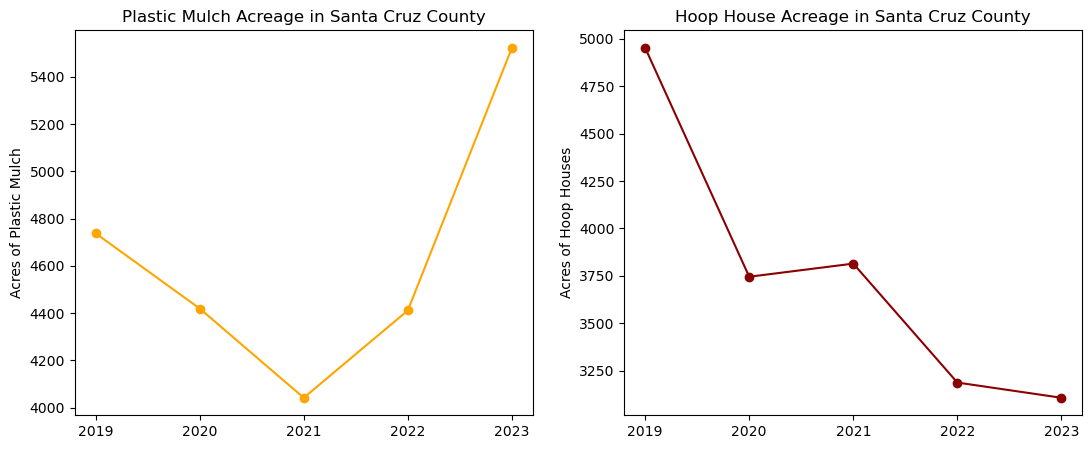

In [97]:
# Plot the change in mulch_acres and hoop_acres over Year side by side
fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(13, 5))

# Plot for Mulch Acres
ax1.plot(df_area['Year'], df_area['Mulch_acres'], marker='o', linestyle='-', color='orange')
ax1.set_ylabel('Acres of Plastic Mulch')
ax1.set_title(f'Plastic Mulch Acreage in {county_name} County')
ax1.set_xticks(df_area['Year'])  # Set x-axis ticks to be the integer values of the year

# Plot for Hoop Acres
ax2.plot(df_area['Year'], df_area['Hoop_acres'], marker='o', linestyle='-', color='darkred')
ax2.set_ylabel('Acres of Hoop Houses')
ax2.set_title(f'Hoop House Acreage in {county_name} County')
ax2.set_xticks(df_area['Year'])  # Set x-axis ticks to be the integer values of the year

plt.show()